# Assignment#4 Code

### Code modified by:
- Andrew Plum
- Leo Bomboy - World bank data

**Date: 11/10/2024**

## Import Packages and Set Settings

In [1]:
import pandas as pd
import numpy as np
import requests
import io
from SPARQLWrapper import SPARQLWrapper, JSON
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor 
from tensorflow import keras

In [3]:
import geopandas as gpd

In [5]:
pd.set_option("display.max_rows", None)

## Query Python SPARQL Endpoint

- Not used in current implementation (code commented out). Left as future work, especially if time allows.
- Currently, the SPARQL queries need to be ran through dbpedia creating a CSV file and then the files need to be dropped into the same folder with this code file.

In [9]:
"""
# SPARQL endpoint
sparql = SPARQLWrapper("http://dbpedia.org/sparql")
query = 
"""

"""
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX dbo: <http://dbpedia.org/ontology/>
PREFIX dbr: <http://dbpedia.org/resource/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX yago: <http://dbpedia.org/class/yago/>
PREFIX gold: <http://purl.org/linguistics/gold/>
PREFIX dbp: <http://dbpedia.org/property/>

SELECT DISTINCT ?country,
                xsd:string(?countryName) AS ?countryName,
                xsd:integer(?censusPopulation) AS ?censusPopulation, 
                ?censusPopulationYear,
                xsd:integer(?estimatePopulation) AS ?estimatePopulation, 
                ?estimatePopulationYear,
                xsd:integer(?totalPopulation) AS ?totalPopulation, 
                xsd:double(?populationDensityKm) AS ?populationDensityKm, 
                ?governmentType,
                (IF(YEAR(NOW()) - YEAR(COALESCE(?foundingDate, NOW())) = 0, -1, 
                    YEAR(NOW()) - YEAR(COALESCE(?foundingDate, NOW()))) AS ?yearsExisted), 
                COUNT(DISTINCT ?conflict) AS ?conflictCount
WHERE {
    ?country rdf:type yago:WikicatCountries , dbo:Country
    {
        ?country gold:hypernym dbr:Country
    }
    UNION
    {
        ?country gold:hypernym dbr:State
    }
    UNION
    {
        ?country gold:hypernym dbr:Republic
    }
    UNION
    {
        ?country gold:hypernym dbr:Nation
    }
    UNION
    {
        ?country gold:hypernym dbr:Kingdom
    }
    UNION
    {
        ?country gold:hypernym dbr:Monarchy
    }
    UNION
    {
        ?country gold:hypernym dbr:Microstate
    }
    UNION
    {
        ?country gold:hypernym dbr:Democracy
    }
    UNION
    {
        ?country gold:hypernym dbr:City
    }
    UNION
    {
        ?country gold:hypernym dbr:Territory
    }

    BIND(STRAFTER(STR(?country), "http://dbpedia.org/resource/") AS ?countryName) .

    OPTIONAL {
        ?country dbp:populationCensus ?censusPopulation .
        ?country dbp:populationCensusYear ?censusPopulationYear .
    }

    OPTIONAL {
        ?country dbp:populationEstimate ?estimatePopulation . 
        ?country dbp:populationEstimateYear ?estimatePopulationYear . 
    }

    OPTIONAL {
        ?country dbo:populationTotal ?totalPopulation .
    }

    OPTIONAL {
        ?country dbp:populationDensityKm ?populationDensityKm .
    }

    OPTIONAL {
        ?country dbo:governmentType ?governmentType .
    }

    OPTIONAL {
        ?country dbo:event ?historicalEvent .
        ?historicalEvent rdf:type dbo:HistoricalEvent .
        ?historicalEvent foaf:name ?eventName .
        ?historicalEvent dbo:startDate ?foundingDate .
        FILTER(REGEX(?eventName, "Current | Constitution | Current constitution | Declared | Recognized", "i"))
    }

    OPTIONAL {
        {
            ?conflict dbo:combatant ?country .
            ?conflict a dbo:MilitaryConflict .
        }
        UNION
        {
            ?conflict dbp:combatant ?country .
            ?conflict a dbo:MilitaryConflict .
        }
        UNION
        {
            ?conflict dbo:place ?country .
            ?conflict a dbo:MilitaryConflict .
        }
    }
} 
GROUP BY ?country
         ?countryName
         ?censusPopulation
         ?censusPopulationYear
         ?estimatePopulation
         ?estimatePopulationYear
         ?totalPopulation
         ?populationDensityKm
         ?governmentType
         ?foundingDate
ORDER BY DESC(?conflictCount)
"""

"""
sparql.setQuery(query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
df = pd.json_normalize(results["results"]["bindings"])
df.to_csv("Query_1_Result.csv", index=False)

print("Query_1_Result.csv Done")
"""

'\nsparql.setQuery(query)\nsparql.setReturnFormat(JSON)\nresults = sparql.query().convert()\ndf = pd.json_normalize(results["results"]["bindings"])\ndf.to_csv("Query_1_Result.csv", index=False)\n\nprint("Query_1_Result.csv Done")\n'

In [11]:
# SPARQL endpoint
"""
sparql = SPARQLWrapper("http://dbpedia.org/sparql")
query = 
"""

"""
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX dbo: <http://dbpedia.org/ontology/>
PREFIX dbr: <http://dbpedia.org/resource/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX yago: <http://dbpedia.org/class/yago/>
PREFIX gold: <http://purl.org/linguistics/gold/>
PREFIX dbp: <http://dbpedia.org/property/>

SELECT DISTINCT ?country,
                xsd:string(?countryName) AS ?countryName,
                ?countryEconomy,
                MAX(xsd:date(?countryEconomyDataDate)) AS ?countryEconomyDataDate,
                ?gdpNominal,
                ?gdpNominalPerCapita,
                ?gdpPpp,
                ?gdpPppPerCapita,
                ?giniCoefficient,
                ?humanDevelopmentIndex,
                AVG(xsd:decimal(?inflationRate)) AS ?inflationRate, 
                AVG(xsd:decimal(?unemploymentRate)) AS ?unemploymentRate,
                AVG(xsd:decimal(?debt)) AS ?debt,
                AVG(xsd:decimal(?grossExternalDebt)) AS ?grossExternalDebt
WHERE {
    # Get correct list of countries
    ?country rdf:type yago:WikicatCountries , dbo:Country
    {
        ?country gold:hypernym dbr:Country
    }
    UNION
    {
        ?country gold:hypernym dbr:State
    }
    UNION
    {
        ?country gold:hypernym dbr:Republic
    }
    UNION
    {
        ?country gold:hypernym dbr:Nation
    }
    UNION
    {
        ?country gold:hypernym dbr:Kingdom
    }
    UNION
    {
        ?country gold:hypernym dbr:Monarchy
    }
    UNION
    {
        ?country gold:hypernym dbr:Microstate
    }
    UNION
    {
        ?country gold:hypernym dbr:Democracy
    }
    UNION
    {
        ?country gold:hypernym dbr:City
    }
    UNION
    {
        ?country gold:hypernym dbr:Territory
    }

    # Get country name
    BIND(STRAFTER(STR(?country), "http://dbpedia.org/resource/") AS ?countryName) .

    # Get country economy object
    FILTER(
            REGEX(STR(?countryEconomy), CONCAT("http://dbpedia.org/resource/Economy_of_", STR(?countryName), ".*"), "i") ||
            REGEX(STR(?countryEconomy), CONCAT("http://dbpedia.org/resource/Economy_of_the_", STR(?countryName), ".*"), "i")
        ) 
    
    # Get country gdpNominal
    OPTIONAL {
        ?country dbp:gdpNominal ?gdpNominal .
        FILTER(DATATYPE(?gdpNominal) = <http://dbpedia.org/datatype/usDollar>)
    }

   # Get country gdpNominalPerCapita
   OPTIONAL {
       ?country dbp:gdpNominalPerCapita ?gdpNominalPerCapita .
       FILTER(DATATYPE(?gdpNominalPerCapita) = <http://dbpedia.org/datatype/usDollar>)
   }

   # Get country gdpPpp
   OPTIONAL {
       ?country dbp:gdpPpp ?gdpPpp .
       FILTER(DATATYPE(?gdpPpp) = <http://dbpedia.org/datatype/usDollar>)
   }

   # Get country gdpPppPerCapita
   OPTIONAL {
       ?country dbp:gdpPppPerCapita ?gdpPppPerCapita .
       FILTER(DATATYPE(?gdpPppPerCapita) = <http://dbpedia.org/datatype/usDollar>)
   }

   # Get country giniCoefficient
   OPTIONAL {
       ?country dbo:giniCoefficient ?giniCoefficient .
   }

   # Get country humanDevelopmentIndex
   OPTIONAL {
       ?country dbo:humanDevelopmentIndex ?humanDevelopmentIndex .
   }

   # Get country inflation rate
   OPTIONAL {
       ?countryEconomy dbp:inflation ?inflationRate .
       FILTER(xsd:decimal(?inflationRate))  
   }

   # Get country unemployment rate
   OPTIONAL {
       ?countryEconomy dbp:unemployment ?unemploymentRate .
       FILTER(xsd:decimal(?unemploymentRate))  
   }

   # Get country debt 
   OPTIONAL {
       ?countryEconomy dbp:debt ?debt .
       FILTER(xsd:decimal(?debt)) 
   }

   # Get country gross external debt 
   OPTIONAL {
       ?countryEconomy dbp:grossExternalDebt ?grossExternalDebt .
       FILTER(xsd:decimal(?grossExternalDebt))     
   }
} 
GROUP BY 
         ?country 
         ?countryName 
         ?countryEconomy  
         ?gdpNominal 
         ?gdpNominalPerCapita 
         ?gdpPpp 
         ?gdpPppPerCapita 
         ?giniCoefficient 
         ?humanDevelopmentIndex 
ORDER BY (?countryName)
"""

"""
sparql.setQuery(query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
df = pd.json_normalize(results["results"]["bindings"])
df.to_csv("Query_2_Result.csv", index=False)

print("Query_2_Result.csv Done")
"""

'\nsparql.setQuery(query)\nsparql.setReturnFormat(JSON)\nresults = sparql.query().convert()\ndf = pd.json_normalize(results["results"]["bindings"])\ndf.to_csv("Query_2_Result.csv", index=False)\n\nprint("Query_2_Result.csv Done")\n'

## Query World Bank

In [14]:
#Query to the World Bank API to retrieve inflation rate, unemployment rate, depttogdp ratio, and several other indicators. 

start_date = 2014
end_date = 2024

indicators = {
    "FP.CPI.TOTL.ZG": "inflation_rate",
    "SL.UEM.TOTL.ZS": "unemployment_rate",
    "GC.DOD.TOTL.GD.ZS": "debt_to_gdp_ratio",
    "BX.KLT.DINV.WD.GD.ZS": "foreign_direct_investment",
    "SP.POP.TOTL": "population",
    "EN.POP.DNST": "population_density_km",
    "SP.DYN.LE00.IN": "years_existed",
    "VC.IHR.PSRC.P5": "homocidesPer100k",
    "NY.GDP.MKTP.CD": "gdp_nominal",
    "NY.GDP.PCAP.PP.CD": "gdp_ppp_per_capita",
    "NY.GDP.PCAP.CD": "gdp_nominal_per_capita",
    "SI.POV.GINI": "gini_coefficient",
    "HD.HCI.OVRL": "human_development_index",
    "DT.DOD.DECT.CD": "gross_external_debt",
}
base_url = "http://api.worldbank.org/v2/country/all/indicator/"
indicator_data = []

for indicator, name in indicators.items():
    url = f"{base_url}{indicator}?date={start_date}:{end_date}&format=json&per_page=20000"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        if len(data) > 1 and "country" in data[1][0]:
            records = [
                {
                    "Country": entry["country"]["value"],
                    "Country Code": entry["countryiso3code"],
                    "Year": entry["date"],
                    name: entry["value"]
                }
                for entry in data[1] if entry["value"] is not None
            ]
            indicator_data.append(pd.DataFrame(records))

if indicator_data:
    df = indicator_data[0]
    for additional_df in indicator_data[1:]:
        df = pd.merge(df, additional_df, on=["Country", "Country Code", "Year"], how="outer")
    df.sort_values(by=["Country", "Year"], ascending=[True, False], inplace=True)
    df.to_csv("world_bank_economic_data.csv", index=False)
    print(df.head())
else:
    print("No data")



       Country Country Code  Year  inflation_rate  unemployment_rate  \
9  Afghanistan          AFG  2023             NaN             14.386   
8  Afghanistan          AFG  2022             NaN             14.100   
7  Afghanistan          AFG  2021             NaN             11.934   
6  Afghanistan          AFG  2020             NaN             11.710   
5  Afghanistan          AFG  2019        2.302373             11.224   

   debt_to_gdp_ratio  foreign_direct_investment  population  \
9                NaN                        NaN  42239854.0   
8                NaN                        NaN  41128771.0   
7                NaN                   0.144401  40099462.0   
6                NaN                   0.064994  38972230.0   
5                NaN                   0.124496  37769499.0   

   population_density_km  years_existed  homocidesPer100k   gdp_nominal  \
9                    NaN            NaN               NaN           NaN   
8                    NaN         62.87

## Load the Data into Pandas Dataframes

In [16]:
print("Query_1_Result_Original.csv")
df1_init = pd.read_csv("Query_1_Result_Original.csv")
print(df1_init.dtypes)

Query_1_Result_Original.csv
country                    object
countryName                object
censusPopulation          float64
censusPopulationYear      float64
estimatePopulation        float64
estimatePopulationYear     object
totalPopulation           float64
populationDensityKm       float64
governmentType             object
yearsExisted                int64
conflictCount               int64
dtype: object


In [17]:
display(df1_init.head())

,country,countryName,censusPopulation,censusPopulationYear,estimatePopulation,estimatePopulationYear,totalPopulation,populationDensityKm,governmentType,yearsExisted,conflictCount
0,http://dbpedia.org/resource/Afghanistan,Afghanistan,19329841.0,1.398763e+14,38346720.0,2022,38346720.0,48.08,http://dbpedia.org/resource/Unitary_state,-1,185
1,http://dbpedia.org/resource/Afghanistan,Afghanistan,19329841.0,1.398763e+14,38346720.0,2022,38346720.0,48.08,http://dbpedia.org/resource/Unitary_state,-1,1
2,http://dbpedia.org/resource/Albania,Albania,2821977.0,1.398763e+14,2793592.0,January 2022,2793592.0,97.00,http://dbpedia.org/resource/Unitary_parliament...,-1,21
3,http://dbpedia.org/resource/Albania,Albania,2821977.0,1.398763e+14,2793592.0,January 2022,2793592.0,97.00,http://dbpedia.org/resource/Unitary_parliament...,-1,19
4,http://dbpedia.org/resource/Algeria,Algeria,73750932.0,1.398763e+14,44700000.0,2021,44700000.0,17.70,http://dbpedia.org/resource/Unitary_state,-1,32


In [18]:
print("Query_2_Result_Original.csv")
df2_init = pd.read_csv("Query_2_Result_Original.csv")
print(df2_init.dtypes)

Query_2_Result_Original.csv
country                    object
countryName                object
countryEconomy             object
countryEconomyDataDate     object
gdpNominal                float64
gdpNominalPerCapita       float64
gdpPpp                    float64
gdpPppPerCapita           float64
giniCoefficient           float64
humanDevelopmentIndex     float64
inflationRate             float64
unemploymentRate          float64
debt                      float64
grossExternalDebt         float64
dtype: object


In [19]:
display(df2_init.head())

,country,countryName,countryEconomy,countryEconomyDataDate,gdpNominal,gdpNominalPerCapita,gdpPpp,gdpPppPerCapita,giniCoefficient,humanDevelopmentIndex,inflationRate,unemploymentRate,debt,grossExternalDebt
0,http://dbpedia.org/resource/Afghanistan,Afghanistan,http://dbpedia.org/resource/Economy_of_Afghani...,2024-11-15,2.165700e+10,493.0,7.291100e+10,2024.0,NaN,0.478,4.5,23.90,7.00,1.400000e+09
1,http://dbpedia.org/resource/Albania,Albania,http://dbpedia.org/resource/Economy_of_Albania,2024-11-15,1.794200e+10,6260.0,4.982700e+10,17383.0,34.299999,0.796,2.0,13.10,65.84,9.505000e+09
2,http://dbpedia.org/resource/Algeria,Algeria,http://dbpedia.org/resource/Economy_of_Algeria,2024-11-15,1.871550e+11,4151.0,6.006680e+11,13324.0,27.600000,0.745,4.1,11.70,27.50,6.260000e+09
3,http://dbpedia.org/resource/Angola,Angola,http://dbpedia.org/resource/Economy_of_Angola,2024-11-15,1.254960e+11,3793.0,2.130340e+11,7360.0,51.299999,0.581,15.0,6.60,65.00,4.208000e+10
4,http://dbpedia.org/resource/Argentina,Argentina,http://dbpedia.org/resource/Economy_of_Argentina,2024-11-15,6.306980e+11,13622.0,1.207000e+12,26074.0,42.900002,0.842,100.0,8.35,186.75,1.074500e+11


In [20]:
print("world_bank_economic_data.csv")
dfWB_init = pd.read_csv("world_bank_economic_data.csv")
print(dfWB_init.dtypes)

world_bank_economic_data.csv
Country                       object
Country Code                  object
Year                           int64
inflation_rate               float64
unemployment_rate            float64
debt_to_gdp_ratio            float64
foreign_direct_investment    float64
population                   float64
population_density_km        float64
years_existed                float64
homocidesPer100k             float64
gdp_nominal                  float64
gdp_ppp_per_capita           float64
gdp_nominal_per_capita       float64
gini_coefficient             float64
human_development_index      float64
gross_external_debt          float64
dtype: object


In [21]:
display(dfWB_init.head())

,Country,Country Code,Year,inflation_rate,unemployment_rate,debt_to_gdp_ratio,foreign_direct_investment,population,population_density_km,years_existed,homocidesPer100k,gdp_nominal,gdp_ppp_per_capita,gdp_nominal_per_capita,gini_coefficient,human_development_index,gross_external_debt
0,Afghanistan,AFG,2023,NaN,14.386,NaN,NaN,42239854.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,2022,NaN,14.100,NaN,NaN,41128771.0,NaN,62.879,NaN,1.450216e+10,2092.879952,352.603733,NaN,NaN,3.393247e+09
2,Afghanistan,AFG,2021,NaN,11.934,NaN,0.144401,40099462.0,61.480554,61.982,4.022498,1.426650e+10,2138.870247,355.777826,NaN,NaN,3.555784e+09
3,Afghanistan,AFG,2020,NaN,11.710,NaN,0.064994,38972230.0,59.752281,62.575,6.594439,1.995593e+10,2568.341909,512.055098,NaN,0.400284,3.040072e+09
4,Afghanistan,AFG,2019,2.302373,11.224,NaN,0.124496,37769499.0,57.908252,63.565,7.180397,1.879944e+10,2589.410396,497.741431,NaN,NaN,2.661686e+09


## Cleaning and Preparing the SPARQL Data for Analysis

### Query 1 data

In [24]:
df1 = df1_init

In [25]:
df1_column_names = df1.columns.tolist()
print(df1_column_names)

['country', 'countryName', 'censusPopulation', 'censusPopulationYear', 'estimatePopulation', 'estimatePopulationYear', 'totalPopulation', 'populationDensityKm', 'governmentType', 'yearsExisted', 'conflictCount']


In [26]:
# do cleaning if needed, display

df1 = df1.drop(columns = ["censusPopulation", "censusPopulationYear", "totalPopulation"])

df1["estimatePopulationYear"] = df1["estimatePopulationYear"].str.extract(r"(\d{4})")

df1 = df1.groupby(
    ["country", "countryName",
     "estimatePopulationYear", "populationDensityKm", 
     "governmentType", "yearsExisted"], as_index = False
).agg({
    "conflictCount": "sum",       # sum the values in conflictCount
    "estimatePopulation": "mean"  # average the values in estimatePopulation
})

df1 = df1.groupby(
    ["country", "countryName", "estimatePopulation", "estimatePopulationYear", "populationDensityKm", "yearsExisted", "conflictCount"], 
    as_index = False
).agg({
    "governmentType": lambda x: ", ".join(x)  # concatenate the strings of governmentType 
})

df1 = df1.drop(df1[df1["estimatePopulation"] == 0].index)

df1["yearsExisted"] = df1["yearsExisted"].replace(-1, np.nan)

display(df1)

,country,countryName,estimatePopulation,estimatePopulationYear,populationDensityKm,yearsExisted,conflictCount,governmentType
0,http://dbpedia.org/resource/Afghanistan,Afghanistan,3.834672e+07,2022,48.080,NaN,186,http://dbpedia.org/resource/Unitary_state
1,http://dbpedia.org/resource/Albania,Albania,2.793592e+06,2022,97.000,NaN,40,http://dbpedia.org/resource/Unitary_parliament...
2,http://dbpedia.org/resource/Algeria,Algeria,4.470000e+07,2021,17.700,NaN,45,http://dbpedia.org/resource/Unitary_state
3,http://dbpedia.org/resource/Andorra,Andorra,7.754300e+04,2020,179.800,NaN,0,http://dbpedia.org/resource/Constitutional_mon...
4,http://dbpedia.org/resource/Angola,Angola,3.479529e+07,2022,24.970,14.0,21,http://dbpedia.org/resource/Unitary_state
5,http://dbpedia.org/resource/Armenia,Armenia,3.000756e+06,2022,101.500,29.0,24,http://dbpedia.org/resource/Unitary_parliament...
6,http://dbpedia.org/resource/Austria,Austria,9.027999e+06,2022,107.600,NaN,29,http://dbpedia.org/resource/Federal_republic
7,http://dbpedia.org/resource/Azerbaijan,Azerbaijan,1.035330e+07,2022,117.000,NaN,23,http://dbpedia.org/resource/Unitary_state
8,http://dbpedia.org/resource/Barbados,Barbados,2.870250e+05,2019,660.000,NaN,3,http://dbpedia.org/resource/Unitary_state
9,http://dbpedia.org/resource/Belarus,Belarus,9.413505e+06,2022,45.800,30.0,35,http://dbpedia.org/resource/Unitary_state


In [27]:
df1_duplicate_counts = df1["countryName"].value_counts()
print(df1_duplicate_counts)

countryName
Afghanistan                         1
Papua_New_Guinea                    1
Niger                               1
Nigeria                             1
North_Korea                         1
Norway                              1
Pakistan                            1
Panama                              1
Paraguay                            1
Saint_Lucia                         1
Peru                                1
Portugal                            1
Qatar                               1
Republic_of_the_Congo               1
Romania                             1
Russia                              1
Nicaragua                           1
Nepal                               1
Nauru                               1
Namibia                             1
Myanmar                             1
Mozambique                          1
Morocco                             1
Montenegro                          1
Mongolia                            1
Monaco                              1


### Query 2 data

In [29]:
df2 = df2_init

In [30]:
df2_column_names = df2.columns.tolist()
print(df2_column_names)

['country', 'countryName', 'countryEconomy', 'countryEconomyDataDate', 'gdpNominal', 'gdpNominalPerCapita', 'gdpPpp', 'gdpPppPerCapita', 'giniCoefficient', 'humanDevelopmentIndex', 'inflationRate', 'unemploymentRate', 'debt', 'grossExternalDebt']


In [31]:
# do cleaning if needed, display

df2 = df2.groupby(
    ["country", "countryName", "countryEconomy", 
     "countryEconomyDataDate", "gdpNominal", 
     "gdpNominalPerCapita", "gdpPppPerCapita", "giniCoefficient", 
     "humanDevelopmentIndex", "inflationRate", "unemploymentRate", 
     "debt", "grossExternalDebt"], as_index = False, dropna = False
).agg({
    "gdpPpp": "mean"   # Average the gdpPpp values
})

df2 = df2.groupby(
    ["country", "countryName", "countryEconomy", 
     "countryEconomyDataDate", "gdpNominal", "gdpPpp",
     "gdpNominalPerCapita", "giniCoefficient", 
     "humanDevelopmentIndex", "inflationRate", "unemploymentRate", 
     "grossExternalDebt"], as_index = False, dropna = False
).agg({
    "debt": "mean"   # Average the gdpPpp values
})

display(df2)

,country,countryName,countryEconomy,countryEconomyDataDate,gdpNominal,gdpPpp,gdpNominalPerCapita,giniCoefficient,humanDevelopmentIndex,inflationRate,unemploymentRate,grossExternalDebt,debt
0,http://dbpedia.org/resource/Afghanistan,Afghanistan,http://dbpedia.org/resource/Economy_of_Afghani...,2024-11-15,2.165700e+10,7.291100e+10,493.0,NaN,0.478,4.500000e+00,2.390000e+01,1.400000e+09,7.000000e+00
1,http://dbpedia.org/resource/Albania,Albania,http://dbpedia.org/resource/Economy_of_Albania,2024-11-15,1.794200e+10,4.982700e+10,6260.0,34.299999,0.796,2.000000e+00,1.310000e+01,9.505000e+09,6.584000e+01
2,http://dbpedia.org/resource/Algeria,Algeria,http://dbpedia.org/resource/Economy_of_Algeria,2024-11-15,1.871550e+11,6.006680e+11,4151.0,27.600000,0.745,4.100000e+00,1.170000e+01,6.260000e+09,2.750000e+01
3,http://dbpedia.org/resource/Angola,Angola,http://dbpedia.org/resource/Economy_of_Angola,2024-11-15,1.254960e+11,2.130340e+11,3793.0,51.299999,0.581,1.500000e+01,6.600000e+00,4.208000e+10,6.500000e+01
4,http://dbpedia.org/resource/Argentina,Argentina,http://dbpedia.org/resource/Economy_of_Argentina,2024-11-15,6.306980e+11,1.207000e+12,13622.0,42.900002,0.842,1.000000e+02,8.350000e+00,1.074500e+11,1.867500e+02
5,http://dbpedia.org/resource/Armenia,Armenia,http://dbpedia.org/resource/Economy_of_Armenia,2024-11-15,1.361200e+10,4.355000e+10,4595.0,29.900000,0.759,8.000000e-01,1.835500e+01,1.041000e+10,5.350000e+01
6,http://dbpedia.org/resource/Aruba,Aruba,http://dbpedia.org/resource/Economy_of_Aruba,2024-11-15,3.400000e+09,4.400000e+09,28898.0,NaN,NaN,3.579000e+00,6.900000e+00,NaN,5.334000e+08
7,http://dbpedia.org/resource/Australia,Australia,http://dbpedia.org/resource/Economy_of_Australia,2024-11-15,1.725000e+12,1.615000e+12,66408.0,32.500000,0.951,2.450000e+00,1.612703e+05,2.095000e+12,6.640000e+01
8,http://dbpedia.org/resource/Austria,Austria,http://dbpedia.org/resource/Economy_of_Austria,2024-11-15,4.798200e+11,5.821300e+11,53320.0,26.700001,0.916,1.600000e+00,7.650000e+00,6.308000e+11,1.402130e+11
9,http://dbpedia.org/resource/Azerbaijan,Azerbaijan,http://dbpedia.org/resource/Economy_of_Azerbaijan,2024-11-15,5.462200e+10,1.607130e+11,5398.0,33.700001,0.756,3.300000e+00,7.766667e+00,8.927000e+09,1.759000e+01


In [33]:
df2_duplicate_counts = df2["countryName"].value_counts()
print(df2_duplicate_counts)

countryName
Afghanistan                       1
Papua_New_Guinea                  1
Niger                             1
Nigeria                           1
Norway                            1
Oman                              1
Pakistan                          1
Panama                            1
Paraguay                          1
Nepal                             1
Peru                              1
Philippines                       1
Poland                            1
Portugal                          1
Qatar                             1
Romania                           1
Nicaragua                         1
Nauru                             1
Lebanon                           1
Maldives                          1
Liberia                           1
Libya                             1
Lithuania                         1
Luxembourg                        1
Malawi                            1
Malaysia                          1
Mali                              1
Namibia         

### World Bank data

In [39]:
dfWB = dfWB_init

In [42]:
dfWB_column_names = dfWB.columns.tolist()
print(dfWB_column_names)

['Country', 'Country Code', 'Year', 'inflation_rate', 'unemployment_rate', 'debt_to_gdp_ratio', 'foreign_direct_investment', 'population', 'population_density_km', 'years_existed', 'homocidesPer100k', 'gdp_nominal', 'gdp_ppp_per_capita', 'gdp_nominal_per_capita', 'gini_coefficient', 'human_development_index', 'gross_external_debt']


In [45]:
dfWB_duplicate_counts = dfWB["Country"].value_counts()
print("Shows country and the number of entries which should correspond to 1 yer per entry:")
print(dfWB_duplicate_counts)

Shows country and the number of entries which should correspond to 1 yer per entry:
Country
Kosovo                                                  13
Nauru                                                   11
Afghanistan                                             10
New Zealand                                             10
North Macedonia                                         10
North America                                           10
Nigeria                                                 10
Niger                                                   10
Nicaragua                                               10
Netherlands                                             10
New Caledonia                                           10
Norway                                                  10
Nepal                                                   10
Namibia                                                 10
Myanmar                                                 10
Mozambique             

In [46]:
print("Number of rows:", len(dfWB))

Number of rows: 2663


In [51]:
print("Number of values by column:")
dfWB.count()

Number of values by column:


Country                      2663
Country Code                 2619
Year                         2663
inflation_rate               2239
unemployment_rate            2347
debt_to_gdp_ratio             802
foreign_direct_investment    2392
population                   2650
population_density_km        2112
years_existed                2318
homocidesPer100k             1185
gdp_nominal                  2546
gdp_ppp_per_capita           2447
gdp_nominal_per_capita       2546
gini_coefficient              662
human_development_index       498
gross_external_debt          1226
dtype: int64

In [53]:
print("Number of null values by column:")
dfWB.isnull().sum()

Number of null values by column:


Country                         0
Country Code                   44
Year                            0
inflation_rate                424
unemployment_rate             316
debt_to_gdp_ratio            1861
foreign_direct_investment     271
population                     13
population_density_km         551
years_existed                 345
homocidesPer100k             1478
gdp_nominal                   117
gdp_ppp_per_capita            216
gdp_nominal_per_capita        117
gini_coefficient             2001
human_development_index      2165
gross_external_debt          1437
dtype: int64

In [55]:
for i, value in enumerate(dfWB["Country"]):
    #print(i, value)
    new_value = ""
    for j in value:
        if j == " ":
            new_value += "_"
        else: 
            new_value += j
    dfWB.at[i, "Country"] = new_value

dfWB_duplicate_counts = dfWB["Country"].value_counts()
print("Shows country and the number of entries which should correspond to 1 yer per entry:")
print(dfWB_duplicate_counts)

Shows country and the number of entries which should correspond to 1 yer per entry:
Country
Kosovo                                                  13
Nauru                                                   11
Afghanistan                                             10
New_Zealand                                             10
North_Macedonia                                         10
North_America                                           10
Nigeria                                                 10
Niger                                                   10
Nicaragua                                               10
Netherlands                                             10
New_Caledonia                                           10
Norway                                                  10
Nepal                                                   10
Namibia                                                 10
Myanmar                                                 10
Mozambique             

In [56]:
dfWB.head(20)

,Country,Country Code,Year,inflation_rate,unemployment_rate,debt_to_gdp_ratio,foreign_direct_investment,population,population_density_km,years_existed,homocidesPer100k,gdp_nominal,gdp_ppp_per_capita,gdp_nominal_per_capita,gini_coefficient,human_development_index,gross_external_debt
0,Afghanistan,AFG,2023,NaN,14.386000,NaN,NaN,42239854.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,2022,NaN,14.100000,NaN,NaN,41128771.0,NaN,62.879000,NaN,1.450216e+10,2092.879952,352.603733,NaN,NaN,3.393247e+09
2,Afghanistan,AFG,2021,NaN,11.934000,NaN,0.144401,40099462.0,61.480554,61.982000,4.022498,1.426650e+10,2138.870247,355.777826,NaN,NaN,3.555784e+09
3,Afghanistan,AFG,2020,NaN,11.710000,NaN,0.064994,38972230.0,59.752281,62.575000,6.594439,1.995593e+10,2568.341909,512.055098,NaN,0.400284,3.040072e+09
4,Afghanistan,AFG,2019,2.302373,11.224000,NaN,0.124496,37769499.0,57.908252,63.565000,7.180397,1.879944e+10,2589.410396,497.741431,NaN,NaN,2.661686e+09
5,Afghanistan,AFG,2018,0.626149,11.206000,NaN,0.661572,36686784.0,56.248231,63.081000,6.743573,1.805322e+10,2436.006320,492.090631,NaN,0.393489,2.678760e+09
6,Afghanistan,AFG,2017,4.975952,11.184000,NaN,0.274797,35643418.0,54.648541,63.016000,6.800695,1.875346e+10,2338.778697,526.140801,NaN,0.389000,2.751987e+09
7,Afghanistan,AFG,2016,4.383892,10.100000,NaN,0.516606,34636207.0,53.104284,63.136000,6.692419,1.811657e+10,2217.296786,523.053012,NaN,NaN,2.596050e+09
8,Afghanistan,AFG,2015,-0.661709,9.011000,NaN,0.884000,33753499.0,51.750915,62.659000,9.975262,1.913422e+10,2289.371986,566.881130,NaN,NaN,2.596917e+09
9,Afghanistan,AFG,2014,4.673996,7.915000,NaN,0.209665,32716210.0,50.160542,62.545000,NaN,2.049713e+10,2229.679539,626.512929,NaN,NaN,2.529865e+09


In [57]:
print("Rename column names:")

new_column_names = {
    "Country": "countryName",
    "Country Code": "countryCode",
    "Year": "year",
    "inflation_rate": "inflationRate",
    "unemployment_rate": "unemploymentRate",
    "debt_to_gdp_ratio": "debtToGdpRatio",
    "foreign_direct_investment": "foreignDirectInvestment",
    "population": "population",
    "population_density_km": "populationDensityKm",
    "years_existed": "yearsExisted",
    "homocidesPer100k": "homicidesPer100k",
    "gdp_nominal": "gdpNominal",
    "gdp_ppp_per_capita": "gdpPppPerCapita",
    "gdp_nominal_per_capita": "gdpNominalPerCapita",
    "gini_coefficient": "giniCoefficient",
    "human_development_index": "humanDevelopmentIndex",
    "gross_external_debt": "grossExternalDebt"
}

dfWB = dfWB.rename(columns = new_column_names)

print()
display(dfWB.head())


Rename column names:



,countryName,countryCode,year,inflationRate,unemploymentRate,debtToGdpRatio,foreignDirectInvestment,population,populationDensityKm,yearsExisted,homicidesPer100k,gdpNominal,gdpPppPerCapita,gdpNominalPerCapita,giniCoefficient,humanDevelopmentIndex,grossExternalDebt
0,Afghanistan,AFG,2023,NaN,14.386,NaN,NaN,42239854.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,2022,NaN,14.100,NaN,NaN,41128771.0,NaN,62.879,NaN,1.450216e+10,2092.879952,352.603733,NaN,NaN,3.393247e+09
2,Afghanistan,AFG,2021,NaN,11.934,NaN,0.144401,40099462.0,61.480554,61.982,4.022498,1.426650e+10,2138.870247,355.777826,NaN,NaN,3.555784e+09
3,Afghanistan,AFG,2020,NaN,11.710,NaN,0.064994,38972230.0,59.752281,62.575,6.594439,1.995593e+10,2568.341909,512.055098,NaN,0.400284,3.040072e+09
4,Afghanistan,AFG,2019,2.302373,11.224,NaN,0.124496,37769499.0,57.908252,63.565,7.180397,1.879944e+10,2589.410396,497.741431,NaN,NaN,2.661686e+09


### Join Query Tables

In [61]:
df_outer = pd.merge(df1, df2, on = "countryName", how = "outer", suffixes = ("_df1", "_df2"))
display(df_outer)

,country_df1,countryName,estimatePopulation,estimatePopulationYear,populationDensityKm,yearsExisted,conflictCount,governmentType,country_df2,countryEconomy,countryEconomyDataDate,gdpNominal,gdpPpp,gdpNominalPerCapita,giniCoefficient,humanDevelopmentIndex,inflationRate,unemploymentRate,grossExternalDebt,debt
0,http://dbpedia.org/resource/Afghanistan,Afghanistan,3.834672e+07,2022,48.080,NaN,186.0,http://dbpedia.org/resource/Unitary_state,http://dbpedia.org/resource/Afghanistan,http://dbpedia.org/resource/Economy_of_Afghani...,2024-11-15,2.165700e+10,7.291100e+10,493.0,NaN,0.478,4.500000e+00,2.390000e+01,1.400000e+09,7.000000e+00
1,http://dbpedia.org/resource/Albania,Albania,2.793592e+06,2022,97.000,NaN,40.0,http://dbpedia.org/resource/Unitary_parliament...,http://dbpedia.org/resource/Albania,http://dbpedia.org/resource/Economy_of_Albania,2024-11-15,1.794200e+10,4.982700e+10,6260.0,34.299999,0.796,2.000000e+00,1.310000e+01,9.505000e+09,6.584000e+01
2,http://dbpedia.org/resource/Algeria,Algeria,4.470000e+07,2021,17.700,NaN,45.0,http://dbpedia.org/resource/Unitary_state,http://dbpedia.org/resource/Algeria,http://dbpedia.org/resource/Economy_of_Algeria,2024-11-15,1.871550e+11,6.006680e+11,4151.0,27.600000,0.745,4.100000e+00,1.170000e+01,6.260000e+09,2.750000e+01
3,http://dbpedia.org/resource/Andorra,Andorra,7.754300e+04,2020,179.800,NaN,0.0,http://dbpedia.org/resource/Constitutional_mon...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,http://dbpedia.org/resource/Angola,Angola,3.479529e+07,2022,24.970,14.0,21.0,http://dbpedia.org/resource/Unitary_state,http://dbpedia.org/resource/Angola,http://dbpedia.org/resource/Economy_of_Angola,2024-11-15,1.254960e+11,2.130340e+11,3793.0,51.299999,0.581,1.500000e+01,6.600000e+00,4.208000e+10,6.500000e+01
5,NaN,Argentina,NaN,NaN,NaN,NaN,NaN,NaN,http://dbpedia.org/resource/Argentina,http://dbpedia.org/resource/Economy_of_Argentina,2024-11-15,6.306980e+11,1.207000e+12,13622.0,42.900002,0.842,1.000000e+02,8.350000e+00,1.074500e+11,1.867500e+02
6,http://dbpedia.org/resource/Armenia,Armenia,3.000756e+06,2022,101.500,29.0,24.0,http://dbpedia.org/resource/Unitary_parliament...,http://dbpedia.org/resource/Armenia,http://dbpedia.org/resource/Economy_of_Armenia,2024-11-15,1.361200e+10,4.355000e+10,4595.0,29.900000,0.759,8.000000e-01,1.835500e+01,1.041000e+10,5.350000e+01
7,NaN,Aruba,NaN,NaN,NaN,NaN,NaN,NaN,http://dbpedia.org/resource/Aruba,http://dbpedia.org/resource/Economy_of_Aruba,2024-11-15,3.400000e+09,4.400000e+09,28898.0,NaN,NaN,3.579000e+00,6.900000e+00,NaN,5.334000e+08
8,NaN,Australia,NaN,NaN,NaN,NaN,NaN,NaN,http://dbpedia.org/resource/Australia,http://dbpedia.org/resource/Economy_of_Australia,2024-11-15,1.725000e+12,1.615000e+12,66408.0,32.500000,0.951,2.450000e+00,1.612703e+05,2.095000e+12,6.640000e+01
9,http://dbpedia.org/resource/Austria,Austria,9.027999e+06,2022,107.600,NaN,29.0,http://dbpedia.org/resource/Federal_republic,http://dbpedia.org/resource/Austria,http://dbpedia.org/resource/Economy_of_Austria,2024-11-15,4.798200e+11,5.821300e+11,53320.0,26.700001,0.916,1.600000e+00,7.650000e+00,6.308000e+11,1.402130e+11


In [64]:
df_inner = pd.merge(df1, df2, on = "countryName", how = "inner", suffixes = ("_df1", "_df2"))
display(df_inner)

,country_df1,countryName,estimatePopulation,estimatePopulationYear,populationDensityKm,yearsExisted,conflictCount,governmentType,country_df2,countryEconomy,countryEconomyDataDate,gdpNominal,gdpPpp,gdpNominalPerCapita,giniCoefficient,humanDevelopmentIndex,inflationRate,unemploymentRate,grossExternalDebt,debt
0,http://dbpedia.org/resource/Afghanistan,Afghanistan,3.834672e+07,2022,48.08,NaN,186,http://dbpedia.org/resource/Unitary_state,http://dbpedia.org/resource/Afghanistan,http://dbpedia.org/resource/Economy_of_Afghani...,2024-11-15,2.165700e+10,7.291100e+10,493.0,NaN,0.478,4.500000,23.900000,1.400000e+09,7.000000e+00
1,http://dbpedia.org/resource/Albania,Albania,2.793592e+06,2022,97.00,NaN,40,http://dbpedia.org/resource/Unitary_parliament...,http://dbpedia.org/resource/Albania,http://dbpedia.org/resource/Economy_of_Albania,2024-11-15,1.794200e+10,4.982700e+10,6260.0,34.299999,0.796,2.000000,13.100000,9.505000e+09,6.584000e+01
2,http://dbpedia.org/resource/Algeria,Algeria,4.470000e+07,2021,17.70,NaN,45,http://dbpedia.org/resource/Unitary_state,http://dbpedia.org/resource/Algeria,http://dbpedia.org/resource/Economy_of_Algeria,2024-11-15,1.871550e+11,6.006680e+11,4151.0,27.600000,0.745,4.100000,11.700000,6.260000e+09,2.750000e+01
3,http://dbpedia.org/resource/Angola,Angola,3.479529e+07,2022,24.97,14.0,21,http://dbpedia.org/resource/Unitary_state,http://dbpedia.org/resource/Angola,http://dbpedia.org/resource/Economy_of_Angola,2024-11-15,1.254960e+11,2.130340e+11,3793.0,51.299999,0.581,15.000000,6.600000,4.208000e+10,6.500000e+01
4,http://dbpedia.org/resource/Armenia,Armenia,3.000756e+06,2022,101.50,29.0,24,http://dbpedia.org/resource/Unitary_parliament...,http://dbpedia.org/resource/Armenia,http://dbpedia.org/resource/Economy_of_Armenia,2024-11-15,1.361200e+10,4.355000e+10,4595.0,29.900000,0.759,0.800000,18.355000,1.041000e+10,5.350000e+01
5,http://dbpedia.org/resource/Austria,Austria,9.027999e+06,2022,107.60,NaN,29,http://dbpedia.org/resource/Federal_republic,http://dbpedia.org/resource/Austria,http://dbpedia.org/resource/Economy_of_Austria,2024-11-15,4.798200e+11,5.821300e+11,53320.0,26.700001,0.916,1.600000,7.650000,6.308000e+11,1.402130e+11
6,http://dbpedia.org/resource/Azerbaijan,Azerbaijan,1.035330e+07,2022,117.00,NaN,23,http://dbpedia.org/resource/Unitary_state,http://dbpedia.org/resource/Azerbaijan,http://dbpedia.org/resource/Economy_of_Azerbaijan,2024-11-15,5.462200e+10,1.607130e+11,5398.0,33.700001,0.756,3.300000,7.766667,8.927000e+09,1.759000e+01
7,http://dbpedia.org/resource/Barbados,Barbados,2.870250e+05,2019,660.00,NaN,3,http://dbpedia.org/resource/Unitary_state,http://dbpedia.org/resource/Barbados,http://dbpedia.org/resource/Economy_of_Barbados,2024-11-15,5.207000e+09,5.398000e+09,18133.0,NaN,0.790,3.688000,10.100000,4.490000e+09,1.573000e+02
8,http://dbpedia.org/resource/Belarus,Belarus,9.413505e+06,2022,45.80,30.0,35,http://dbpedia.org/resource/Unitary_state,http://dbpedia.org/resource/Belarus,http://dbpedia.org/resource/Economy_of_Belarus,2024-11-15,5.770800e+10,1.858890e+11,6133.0,25.299999,0.808,4.800000,4.800000,3.992000e+10,5.340000e+01
9,http://dbpedia.org/resource/Belgium,Belgium,1.158401e+07,2022,376.00,NaN,112,http://dbpedia.org/resource/Constitutional_mon...,http://dbpedia.org/resource/Belgium,http://dbpedia.org/resource/Economy_of_Belgium,2024-11-15,5.894900e+11,NaN,50598.0,23.900000,0.931,1.366667,9.050000,1.281000e+12,2.335800e+11


### Use df_outer as dfQ

In [68]:
dfQ = df_outer # dfQ stands for dfQuery as in SPARQL queries

In [70]:
dfQ_columns = dfQ.columns.tolist()
print(dfQ_columns)

['country_df1', 'countryName', 'estimatePopulation', 'estimatePopulationYear', 'populationDensityKm', 'yearsExisted', 'conflictCount', 'governmentType', 'country_df2', 'countryEconomy', 'countryEconomyDataDate', 'gdpNominal', 'gdpPpp', 'gdpNominalPerCapita', 'giniCoefficient', 'humanDevelopmentIndex', 'inflationRate', 'unemploymentRate', 'grossExternalDebt', 'debt']


### Drop Unnecessary Columns in dfQ

***Note:*** 
- I am deciding to drop "countryEconomyDataDate" and will instead use "estimatePopulationYear" which will be renamed to just "year" because:
    - "countryEconomyDataDate" was only an assumed date anyway.
    - And as far as I can tell, the population numbers given and also the years when present between the country page and country economy pages on dbpedia mostly match leading me to believe the year given also applies to the economic numbers. 

In [76]:
dfQ = dfQ.drop("country_df1", axis = 1)
dfQ = dfQ.drop("country_df2", axis = 1)
dfQ = dfQ.drop("countryEconomy", axis = 1)
dfQ = dfQ.drop("countryEconomyDataDate", axis = 1)
dfQ.head()

,countryName,estimatePopulation,estimatePopulationYear,populationDensityKm,yearsExisted,conflictCount,governmentType,gdpNominal,gdpPpp,gdpNominalPerCapita,giniCoefficient,humanDevelopmentIndex,inflationRate,unemploymentRate,grossExternalDebt,debt
0,Afghanistan,38346720.0,2022,48.08,NaN,186.0,http://dbpedia.org/resource/Unitary_state,2.165700e+10,7.291100e+10,493.0,NaN,0.478,4.5,23.9,1.400000e+09,7.00
1,Albania,2793592.0,2022,97.00,NaN,40.0,http://dbpedia.org/resource/Unitary_parliament...,1.794200e+10,4.982700e+10,6260.0,34.299999,0.796,2.0,13.1,9.505000e+09,65.84
2,Algeria,44700000.0,2021,17.70,NaN,45.0,http://dbpedia.org/resource/Unitary_state,1.871550e+11,6.006680e+11,4151.0,27.600000,0.745,4.1,11.7,6.260000e+09,27.50
3,Andorra,77543.0,2020,179.80,NaN,0.0,http://dbpedia.org/resource/Constitutional_mon...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,34795287.0,2022,24.97,14.0,21.0,http://dbpedia.org/resource/Unitary_state,1.254960e+11,2.130340e+11,3793.0,51.299999,0.581,15.0,6.6,4.208000e+10,65.00


### Rename Columns in dfQ

In [80]:
new_column_names = {
    "countryName": "countryName",
    "estimatePopulation": "population",
    "estimatePopulationYear": "year",
    "populationDensityKm": "populationDensityKm",
    "yearsExisted": "yearsExisted",
    "conflictCount": "conflictCount",
    "governmentType": "governmentType",
    "gdpNominal": "gdpNominal",
    "gdpPpp": "gdpPpp",
    "gdpNominalPerCapita": "gdpNominalPerCapita",
    "giniCoefficient": "giniCoefficient",
    "humanDevelopmentIndex": "humanDevelopmentIndex",
    "inflationRate": "inflationRate",
    "unemploymentRate": "unemploymentRate",
    "grossExternalDebt": "grossExternalDebt",
    "debt": "debt"
}

dfQ = dfQ.rename(columns = new_column_names)

print()
display(dfQ.head(5))

,countryName,population,year,populationDensityKm,yearsExisted,conflictCount,governmentType,gdpNominal,gdpPpp,gdpNominalPerCapita,giniCoefficient,humanDevelopmentIndex,inflationRate,unemploymentRate,grossExternalDebt,debt
0,Afghanistan,38346720.0,2022,48.08,NaN,186.0,http://dbpedia.org/resource/Unitary_state,2.165700e+10,7.291100e+10,493.0,NaN,0.478,4.5,23.9,1.400000e+09,7.00
1,Albania,2793592.0,2022,97.00,NaN,40.0,http://dbpedia.org/resource/Unitary_parliament...,1.794200e+10,4.982700e+10,6260.0,34.299999,0.796,2.0,13.1,9.505000e+09,65.84
2,Algeria,44700000.0,2021,17.70,NaN,45.0,http://dbpedia.org/resource/Unitary_state,1.871550e+11,6.006680e+11,4151.0,27.600000,0.745,4.1,11.7,6.260000e+09,27.50
3,Andorra,77543.0,2020,179.80,NaN,0.0,http://dbpedia.org/resource/Constitutional_mon...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,34795287.0,2022,24.97,14.0,21.0,http://dbpedia.org/resource/Unitary_state,1.254960e+11,2.130340e+11,3793.0,51.299999,0.581,15.0,6.6,4.208000e+10,65.00


### Clean governmentType Value in dfQ

In [83]:
dfQ["governmentType"] = dfQ["governmentType"].str.replace("http://dbpedia.org/resource/", "", regex=False)
display(dfQ.head(5))

,countryName,population,year,populationDensityKm,yearsExisted,conflictCount,governmentType,gdpNominal,gdpPpp,gdpNominalPerCapita,giniCoefficient,humanDevelopmentIndex,inflationRate,unemploymentRate,grossExternalDebt,debt
0,Afghanistan,38346720.0,2022,48.08,NaN,186.0,Unitary_state,2.165700e+10,7.291100e+10,493.0,NaN,0.478,4.5,23.9,1.400000e+09,7.00
1,Albania,2793592.0,2022,97.00,NaN,40.0,Unitary_parliamentary_republic,1.794200e+10,4.982700e+10,6260.0,34.299999,0.796,2.0,13.1,9.505000e+09,65.84
2,Algeria,44700000.0,2021,17.70,NaN,45.0,Unitary_state,1.871550e+11,6.006680e+11,4151.0,27.600000,0.745,4.1,11.7,6.260000e+09,27.50
3,Andorra,77543.0,2020,179.80,NaN,0.0,"Constitutional_monarchy, Unitary_state",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,34795287.0,2022,24.97,14.0,21.0,Unitary_state,1.254960e+11,2.130340e+11,3793.0,51.299999,0.581,15.0,6.6,4.208000e+10,65.00


### Change Types of Columns in dfQ

In [87]:
print(dfQ.dtypes)

countryName               object
population               float64
year                      object
populationDensityKm      float64
yearsExisted             float64
conflictCount            float64
governmentType            object
gdpNominal               float64
gdpPpp                   float64
gdpNominalPerCapita      float64
giniCoefficient          float64
humanDevelopmentIndex    float64
inflationRate            float64
unemploymentRate         float64
grossExternalDebt        float64
debt                     float64
dtype: object


In [89]:
dfQ["year"] = pd.to_numeric(dfQ["year"], errors = "coerce") # # convert to numeric, keeping NaN values
dfQ["yearsExisted"] = dfQ["yearsExisted"].astype(float)
dfQ["conflictCount"] = dfQ["conflictCount"].astype(float)

dfQ.head(10)

,countryName,population,year,populationDensityKm,yearsExisted,conflictCount,governmentType,gdpNominal,gdpPpp,gdpNominalPerCapita,giniCoefficient,humanDevelopmentIndex,inflationRate,unemploymentRate,grossExternalDebt,debt
0,Afghanistan,38346720.0,2022.0,48.08,NaN,186.0,Unitary_state,2.165700e+10,7.291100e+10,493.0,NaN,0.478,4.500,23.900,1.400000e+09,7.000000e+00
1,Albania,2793592.0,2022.0,97.00,NaN,40.0,Unitary_parliamentary_republic,1.794200e+10,4.982700e+10,6260.0,34.299999,0.796,2.000,13.100,9.505000e+09,6.584000e+01
2,Algeria,44700000.0,2021.0,17.70,NaN,45.0,Unitary_state,1.871550e+11,6.006680e+11,4151.0,27.600000,0.745,4.100,11.700,6.260000e+09,2.750000e+01
3,Andorra,77543.0,2020.0,179.80,NaN,0.0,"Constitutional_monarchy, Unitary_state",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,34795287.0,2022.0,24.97,14.0,21.0,Unitary_state,1.254960e+11,2.130340e+11,3793.0,51.299999,0.581,15.000,6.600,4.208000e+10,6.500000e+01
5,Argentina,NaN,NaN,NaN,NaN,NaN,NaN,6.306980e+11,1.207000e+12,13622.0,42.900002,0.842,100.000,8.350,1.074500e+11,1.867500e+02
6,Armenia,3000756.0,2022.0,101.50,29.0,24.0,Unitary_parliamentary_republic,1.361200e+10,4.355000e+10,4595.0,29.900000,0.759,0.800,18.355,1.041000e+10,5.350000e+01
7,Aruba,NaN,NaN,NaN,NaN,NaN,NaN,3.400000e+09,4.400000e+09,28898.0,NaN,NaN,3.579,6.900,NaN,5.334000e+08
8,Australia,NaN,NaN,NaN,NaN,NaN,NaN,1.725000e+12,1.615000e+12,66408.0,32.500000,0.951,2.450,161270.300,2.095000e+12,6.640000e+01
9,Austria,9027999.0,2022.0,107.60,NaN,29.0,Federal_republic,4.798200e+11,5.821300e+11,53320.0,26.700001,0.916,1.600,7.650,6.308000e+11,1.402130e+11


In [92]:
print(dfQ.dtypes)

countryName               object
population               float64
year                     float64
populationDensityKm      float64
yearsExisted             float64
conflictCount            float64
governmentType            object
gdpNominal               float64
gdpPpp                   float64
gdpNominalPerCapita      float64
giniCoefficient          float64
humanDevelopmentIndex    float64
inflationRate            float64
unemploymentRate         float64
grossExternalDebt        float64
debt                     float64
dtype: object


### Change Types of Columns in dfWB

In [95]:
print(dfWB.dtypes)

countryName                 object
countryCode                 object
year                         int64
inflationRate              float64
unemploymentRate           float64
debtToGdpRatio             float64
foreignDirectInvestment    float64
population                 float64
populationDensityKm        float64
yearsExisted               float64
homicidesPer100k           float64
gdpNominal                 float64
gdpPppPerCapita            float64
gdpNominalPerCapita        float64
giniCoefficient            float64
humanDevelopmentIndex      float64
grossExternalDebt          float64
dtype: object


In [97]:
dfWB["year"] = dfWB["year"].astype(float)

display(dfWB.head(10))

,countryName,countryCode,year,inflationRate,unemploymentRate,debtToGdpRatio,foreignDirectInvestment,population,populationDensityKm,yearsExisted,homicidesPer100k,gdpNominal,gdpPppPerCapita,gdpNominalPerCapita,giniCoefficient,humanDevelopmentIndex,grossExternalDebt
0,Afghanistan,AFG,2023.0,NaN,14.386,NaN,NaN,42239854.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,2022.0,NaN,14.100,NaN,NaN,41128771.0,NaN,62.879,NaN,1.450216e+10,2092.879952,352.603733,NaN,NaN,3.393247e+09
2,Afghanistan,AFG,2021.0,NaN,11.934,NaN,0.144401,40099462.0,61.480554,61.982,4.022498,1.426650e+10,2138.870247,355.777826,NaN,NaN,3.555784e+09
3,Afghanistan,AFG,2020.0,NaN,11.710,NaN,0.064994,38972230.0,59.752281,62.575,6.594439,1.995593e+10,2568.341909,512.055098,NaN,0.400284,3.040072e+09
4,Afghanistan,AFG,2019.0,2.302373,11.224,NaN,0.124496,37769499.0,57.908252,63.565,7.180397,1.879944e+10,2589.410396,497.741431,NaN,NaN,2.661686e+09
5,Afghanistan,AFG,2018.0,0.626149,11.206,NaN,0.661572,36686784.0,56.248231,63.081,6.743573,1.805322e+10,2436.006320,492.090631,NaN,0.393489,2.678760e+09
6,Afghanistan,AFG,2017.0,4.975952,11.184,NaN,0.274797,35643418.0,54.648541,63.016,6.800695,1.875346e+10,2338.778697,526.140801,NaN,0.389000,2.751987e+09
7,Afghanistan,AFG,2016.0,4.383892,10.100,NaN,0.516606,34636207.0,53.104284,63.136,6.692419,1.811657e+10,2217.296786,523.053012,NaN,NaN,2.596050e+09
8,Afghanistan,AFG,2015.0,-0.661709,9.011,NaN,0.884000,33753499.0,51.750915,62.659,9.975262,1.913422e+10,2289.371986,566.881130,NaN,NaN,2.596917e+09
9,Afghanistan,AFG,2014.0,4.673996,7.915,NaN,0.209665,32716210.0,50.160542,62.545,NaN,2.049713e+10,2229.679539,626.512929,NaN,NaN,2.529865e+09


In [99]:
print(dfWB.dtypes)

countryName                 object
countryCode                 object
year                       float64
inflationRate              float64
unemploymentRate           float64
debtToGdpRatio             float64
foreignDirectInvestment    float64
population                 float64
populationDensityKm        float64
yearsExisted               float64
homicidesPer100k           float64
gdpNominal                 float64
gdpPppPerCapita            float64
gdpNominalPerCapita        float64
giniCoefficient            float64
humanDevelopmentIndex      float64
grossExternalDebt          float64
dtype: object


### New Columns of Both Dataframes

In [102]:
dfWB_columns = dfWB.columns.tolist()
dfQ_columns = dfQ.columns.tolist()

print("dfWB_columns:\n", dfWB_columns)
print()
print("dfQ_columns:\n", dfQ_columns)

dfWB_columns:
 ['countryName', 'countryCode', 'year', 'inflationRate', 'unemploymentRate', 'debtToGdpRatio', 'foreignDirectInvestment', 'population', 'populationDensityKm', 'yearsExisted', 'homicidesPer100k', 'gdpNominal', 'gdpPppPerCapita', 'gdpNominalPerCapita', 'giniCoefficient', 'humanDevelopmentIndex', 'grossExternalDebt']

dfQ_columns:
 ['countryName', 'population', 'year', 'populationDensityKm', 'yearsExisted', 'conflictCount', 'governmentType', 'gdpNominal', 'gdpPpp', 'gdpNominalPerCapita', 'giniCoefficient', 'humanDevelopmentIndex', 'inflationRate', 'unemploymentRate', 'grossExternalDebt', 'debt']


### Reorder Columns of Both Dataframes

In [105]:
shared_columns = list(set(dfWB.columns) & set(dfQ.columns))

print("Shared columns:")
print(shared_columns)

Shared columns:
['giniCoefficient', 'populationDensityKm', 'gdpNominal', 'countryName', 'year', 'grossExternalDebt', 'unemploymentRate', 'humanDevelopmentIndex', 'gdpNominalPerCapita', 'population', 'inflationRate', 'yearsExisted']


In [107]:
dfWB_unique = [col for col in dfWB.columns if col not in shared_columns]
dfQ_unique = [col for col in dfQ.columns if col not in shared_columns]

print("dfWB_unique:\n", dfWB_unique)
print()
print("dfQ_unique:\n", dfQ_unique)

dfWB_unique:
 ['countryCode', 'debtToGdpRatio', 'foreignDirectInvestment', 'homicidesPer100k', 'gdpPppPerCapita']

dfQ_unique:
 ['conflictCount', 'governmentType', 'gdpPpp', 'debt']


In [109]:
shared_order = ["countryName", "year", "population", "populationDensityKm", "yearsExisted", 
                "gdpNominal", "gdpNominalPerCapita", "giniCoefficient", "humanDevelopmentIndex", 
                "inflationRate", "unemploymentRate", "grossExternalDebt"]

dfWB = dfWB[shared_order + dfWB_unique]
dfQ = dfQ[shared_order + dfQ_unique]

dfWB_columns = dfWB.columns.tolist()
dfQ_columns = dfQ.columns.tolist()

print("dfWB_columns:\n", dfWB_columns)
print()
print("dfQ_columns:\n", dfQ_columns)

dfWB_columns:
 ['countryName', 'year', 'population', 'populationDensityKm', 'yearsExisted', 'gdpNominal', 'gdpNominalPerCapita', 'giniCoefficient', 'humanDevelopmentIndex', 'inflationRate', 'unemploymentRate', 'grossExternalDebt', 'countryCode', 'debtToGdpRatio', 'foreignDirectInvestment', 'homicidesPer100k', 'gdpPppPerCapita']

dfQ_columns:
 ['countryName', 'year', 'population', 'populationDensityKm', 'yearsExisted', 'gdpNominal', 'gdpNominalPerCapita', 'giniCoefficient', 'humanDevelopmentIndex', 'inflationRate', 'unemploymentRate', 'grossExternalDebt', 'conflictCount', 'governmentType', 'gdpPpp', 'debt']


### Datatypes of Columns

In [112]:
print(dfWB.dtypes)
print()
print(dfQ.dtypes)

countryName                 object
year                       float64
population                 float64
populationDensityKm        float64
yearsExisted               float64
gdpNominal                 float64
gdpNominalPerCapita        float64
giniCoefficient            float64
humanDevelopmentIndex      float64
inflationRate              float64
unemploymentRate           float64
grossExternalDebt          float64
countryCode                 object
debtToGdpRatio             float64
foreignDirectInvestment    float64
homicidesPer100k           float64
gdpPppPerCapita            float64
dtype: object

countryName               object
year                     float64
population               float64
populationDensityKm      float64
yearsExisted             float64
gdpNominal               float64
gdpNominalPerCapita      float64
giniCoefficient          float64
humanDevelopmentIndex    float64
inflationRate            float64
unemploymentRate         float64
grossExternalDebt        fl

### Save Preprocessed Dataframes - Still Contain NULL Values

In [115]:
dfWB_clean_w_null = dfWB
dfQ_clean_w_null = dfQ

display(dfWB_clean_w_null.head())
display(dfQ_clean_w_null.head())

,countryName,year,population,populationDensityKm,yearsExisted,gdpNominal,gdpNominalPerCapita,giniCoefficient,humanDevelopmentIndex,inflationRate,unemploymentRate,grossExternalDebt,countryCode,debtToGdpRatio,foreignDirectInvestment,homicidesPer100k,gdpPppPerCapita
0,Afghanistan,2023.0,42239854.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.386,NaN,AFG,NaN,NaN,NaN,NaN
1,Afghanistan,2022.0,41128771.0,NaN,62.879,1.450216e+10,352.603733,NaN,NaN,NaN,14.100,3.393247e+09,AFG,NaN,NaN,NaN,2092.879952
2,Afghanistan,2021.0,40099462.0,61.480554,61.982,1.426650e+10,355.777826,NaN,NaN,NaN,11.934,3.555784e+09,AFG,NaN,0.144401,4.022498,2138.870247
3,Afghanistan,2020.0,38972230.0,59.752281,62.575,1.995593e+10,512.055098,NaN,0.400284,NaN,11.710,3.040072e+09,AFG,NaN,0.064994,6.594439,2568.341909
4,Afghanistan,2019.0,37769499.0,57.908252,63.565,1.879944e+10,497.741431,NaN,NaN,2.302373,11.224,2.661686e+09,AFG,NaN,0.124496,7.180397,2589.410396


,countryName,year,population,populationDensityKm,yearsExisted,gdpNominal,gdpNominalPerCapita,giniCoefficient,humanDevelopmentIndex,inflationRate,unemploymentRate,grossExternalDebt,conflictCount,governmentType,gdpPpp,debt
0,Afghanistan,2022.0,38346720.0,48.08,NaN,2.165700e+10,493.0,NaN,0.478,4.5,23.9,1.400000e+09,186.0,Unitary_state,7.291100e+10,7.00
1,Albania,2022.0,2793592.0,97.00,NaN,1.794200e+10,6260.0,34.299999,0.796,2.0,13.1,9.505000e+09,40.0,Unitary_parliamentary_republic,4.982700e+10,65.84
2,Algeria,2021.0,44700000.0,17.70,NaN,1.871550e+11,4151.0,27.600000,0.745,4.1,11.7,6.260000e+09,45.0,Unitary_state,6.006680e+11,27.50
3,Andorra,2020.0,77543.0,179.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,"Constitutional_monarchy, Unitary_state",NaN,NaN
4,Angola,2022.0,34795287.0,24.97,14.0,1.254960e+11,3793.0,51.299999,0.581,15.0,6.6,4.208000e+10,21.0,Unitary_state,2.130340e+11,65.00


## Exploratory Data Analysis (EDA) of dfQ

### Basic Information on dfQ

In [119]:
display(dfQ.head())
print()

print("Shape of the DataFrame:")
print(dfQ.shape)
print()

print(dfQ.info())
print()

null_counts = dfQ.isnull().sum()
print("NULL Values Count:")
print(null_counts[null_counts > 0])
print()

null_percentage = (dfQ.isnull().sum() / len(dfQ)) * 100
print("Percentage of NULL Values (out of 100%):")
print(null_percentage[null_percentage > 0])
print()

print("Descriptive Statistics:")
print(dfQ.describe())
print()

print("Categorical Statistics")
print(dfQ.describe(include=["object"]))
print()

,countryName,year,population,populationDensityKm,yearsExisted,gdpNominal,gdpNominalPerCapita,giniCoefficient,humanDevelopmentIndex,inflationRate,unemploymentRate,grossExternalDebt,conflictCount,governmentType,gdpPpp,debt
0,Afghanistan,2022.0,38346720.0,48.08,NaN,2.165700e+10,493.0,NaN,0.478,4.5,23.9,1.400000e+09,186.0,Unitary_state,7.291100e+10,7.00
1,Albania,2022.0,2793592.0,97.00,NaN,1.794200e+10,6260.0,34.299999,0.796,2.0,13.1,9.505000e+09,40.0,Unitary_parliamentary_republic,4.982700e+10,65.84
2,Algeria,2021.0,44700000.0,17.70,NaN,1.871550e+11,4151.0,27.600000,0.745,4.1,11.7,6.260000e+09,45.0,Unitary_state,6.006680e+11,27.50
3,Andorra,2020.0,77543.0,179.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,"Constitutional_monarchy, Unitary_state",NaN,NaN
4,Angola,2022.0,34795287.0,24.97,14.0,1.254960e+11,3793.0,51.299999,0.581,15.0,6.6,4.208000e+10,21.0,Unitary_state,2.130340e+11,65.00



Shape of the DataFrame:
(164, 16)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   countryName            164 non-null    object 
 1   year                   139 non-null    float64
 2   population             139 non-null    float64
 3   populationDensityKm    139 non-null    float64
 4   yearsExisted           62 non-null     float64
 5   gdpNominal             133 non-null    float64
 6   gdpNominalPerCapita    139 non-null    float64
 7   giniCoefficient        126 non-null    float64
 8   humanDevelopmentIndex  137 non-null    float64
 9   inflationRate          139 non-null    float64
 10  unemploymentRate       131 non-null    float64
 11  grossExternalDebt      123 non-null    float64
 12  conflictCount          139 non-null    float64
 13  governmentType         139 non-null    object 
 14  gdpPpp                

### Heatmap of Missing Values in dfQ

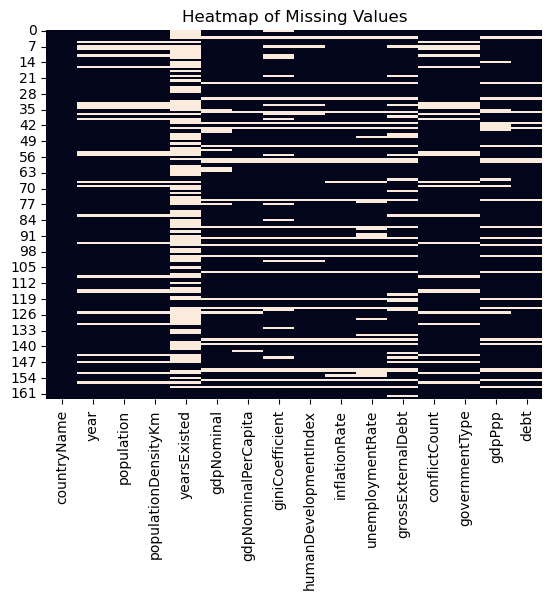

In [122]:
plt.figure()
sns.heatmap(dfQ.isnull(), cbar = False)
plt.title("Heatmap of Missing Values")
plt.show()

### Pair Plot of dfQ

In [125]:
# This commented out code takes a very long time to run
# The code is commented out by default so you can run all cells and it finishes running in a reasonable amount of time 
# Uncomment code below to see the pair plot
"""
numeric_cols = dfQ.select_dtypes(include=["float64", "int64"]).columns
sns.pairplot(dfQ[numeric_cols])
plt.title("Pair Plot of Numeric Features")
plt.show()
"""
print("Done")

Done


### Correlation Matrix of Data in dfQ

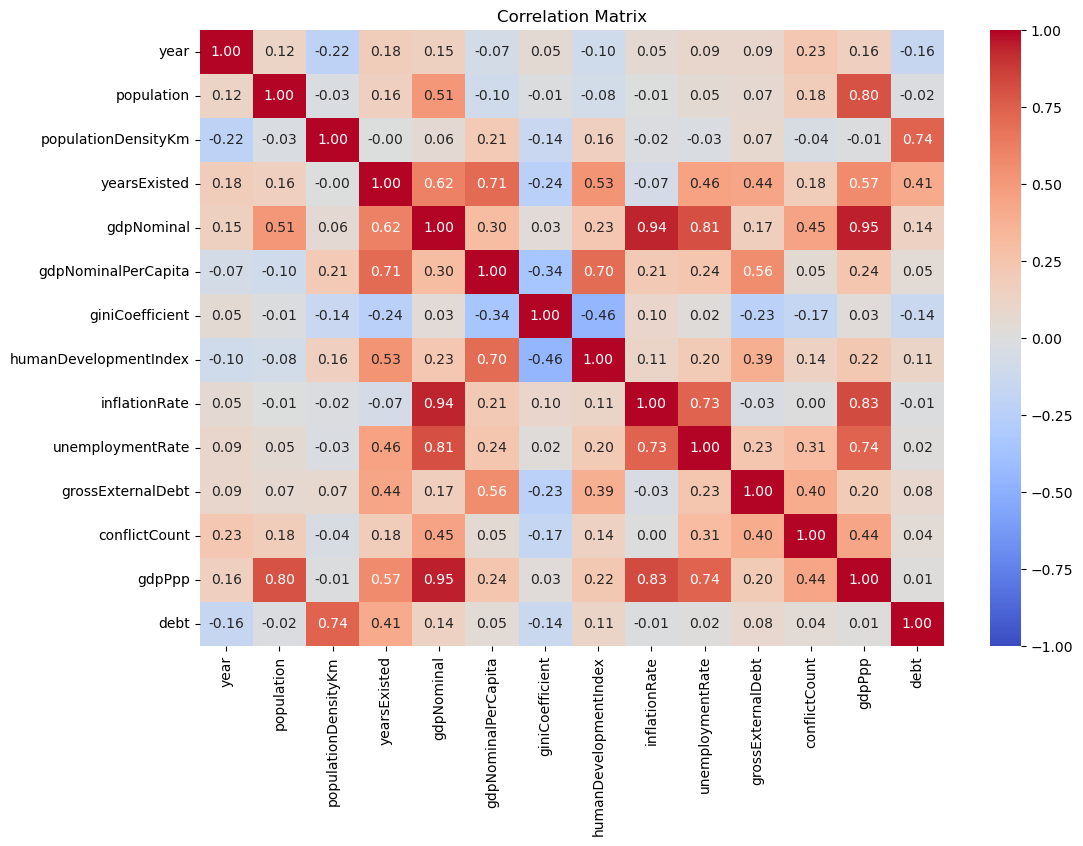

In [128]:
correlation_matrix = dfQ.corr(numeric_only = True)
plt.figure(figsize = (12, 8))
sns.heatmap(correlation_matrix, annot = True, fmt = ".2f", cmap = "coolwarm", vmax = 1, vmin = -1)
plt.title("Correlation Matrix")
plt.show()

### Histograms of dfQ Data Up Close

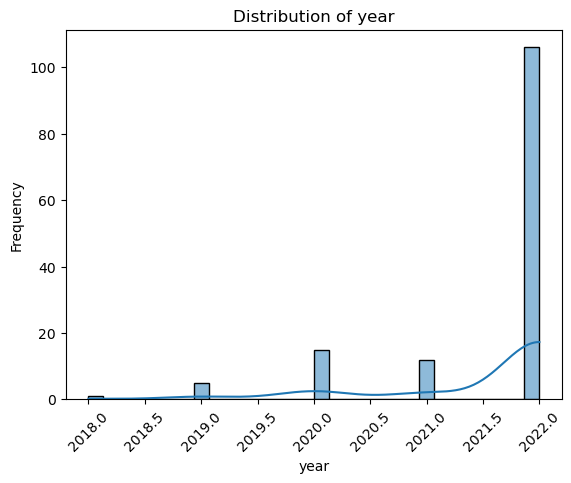

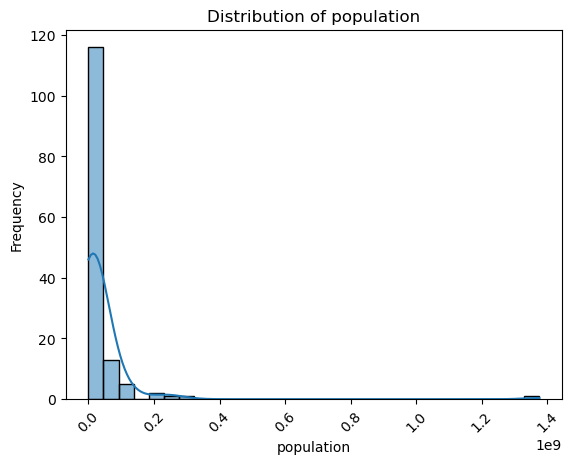

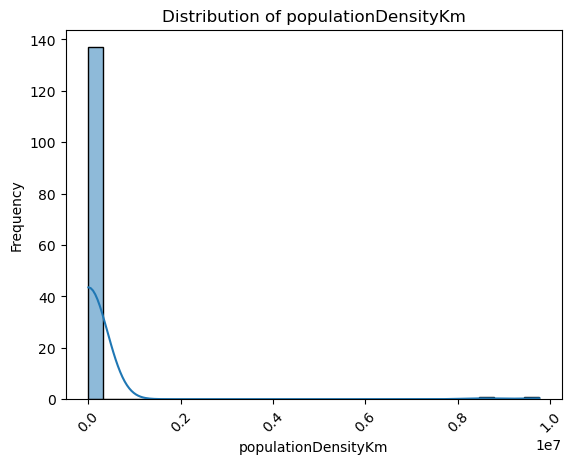

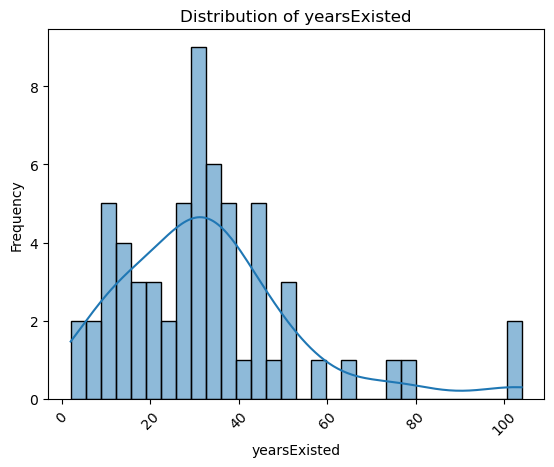

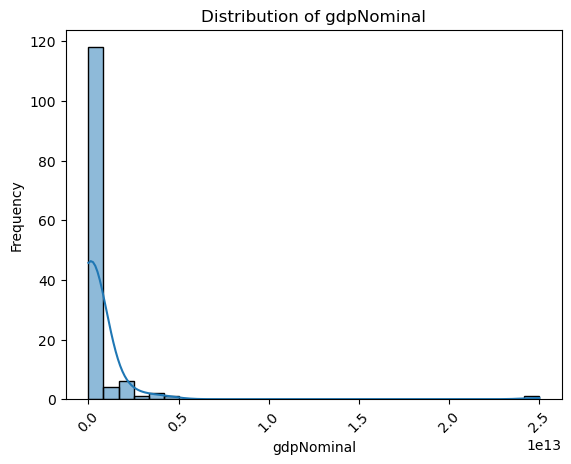

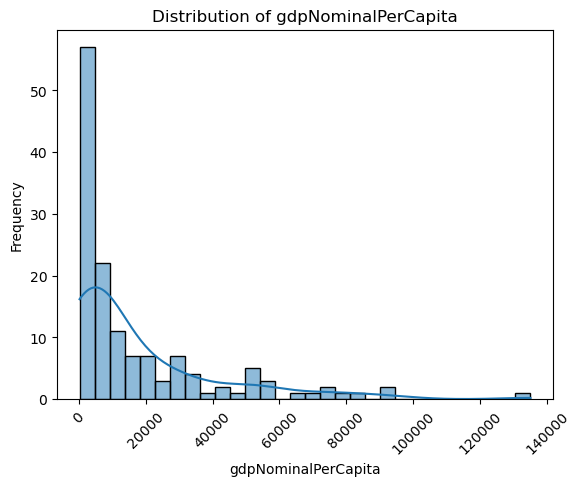

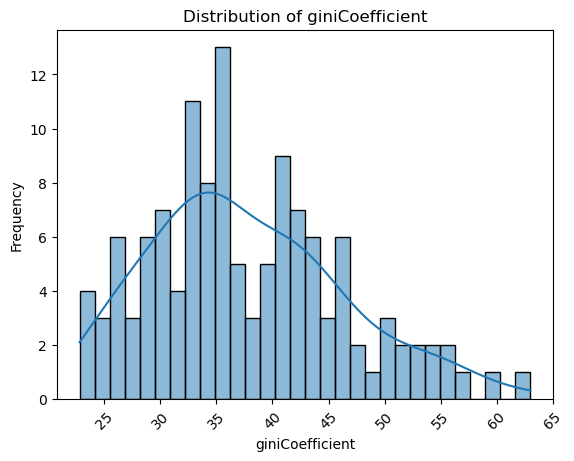

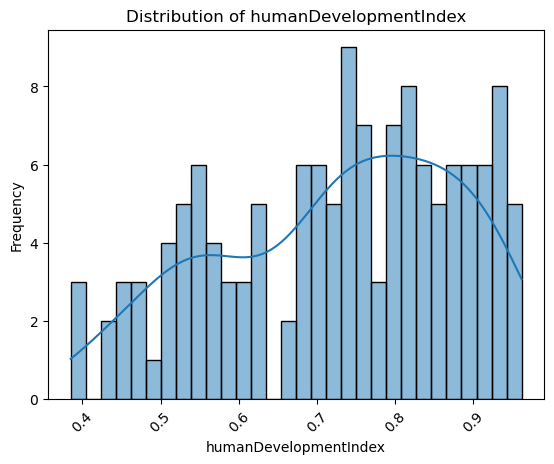

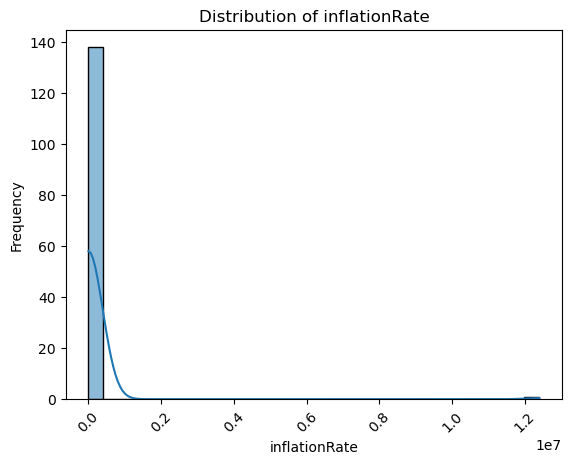

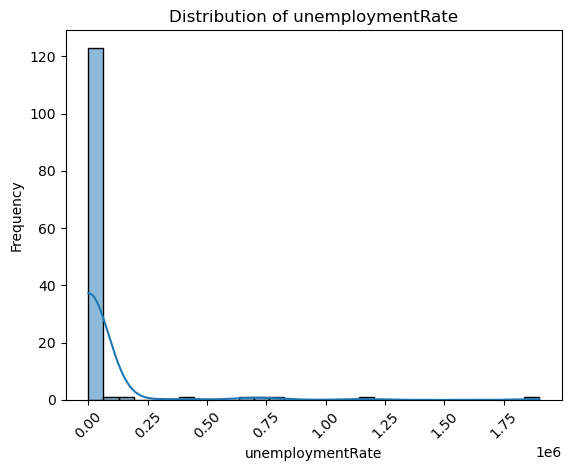

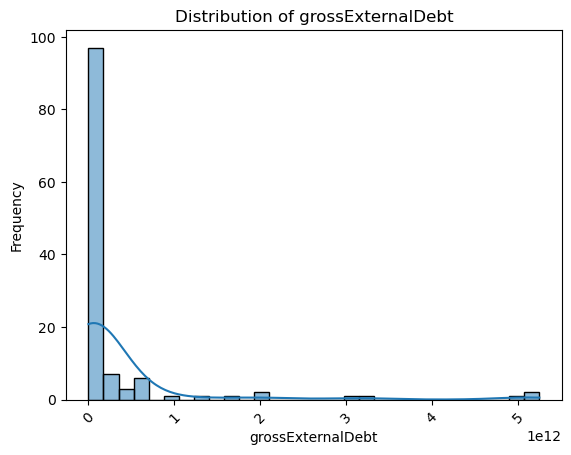

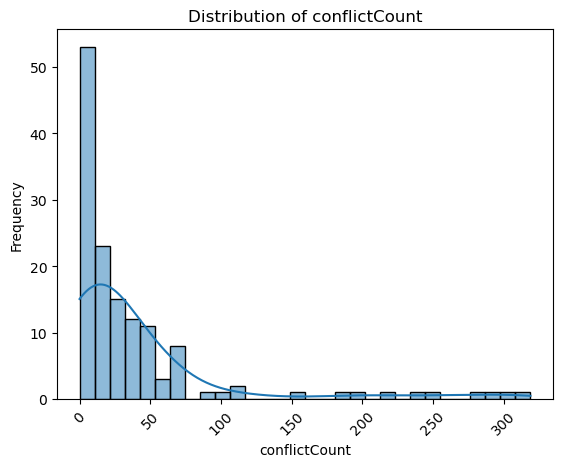

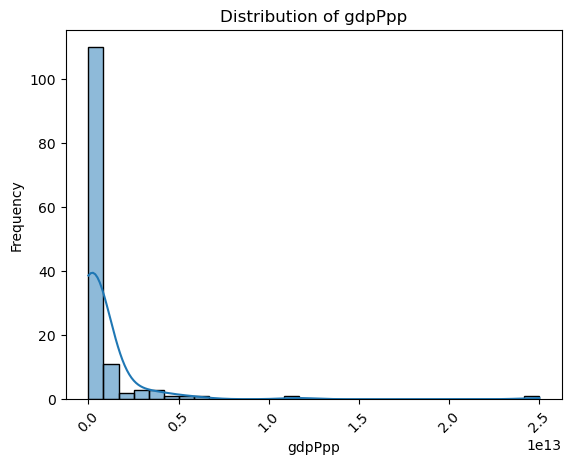

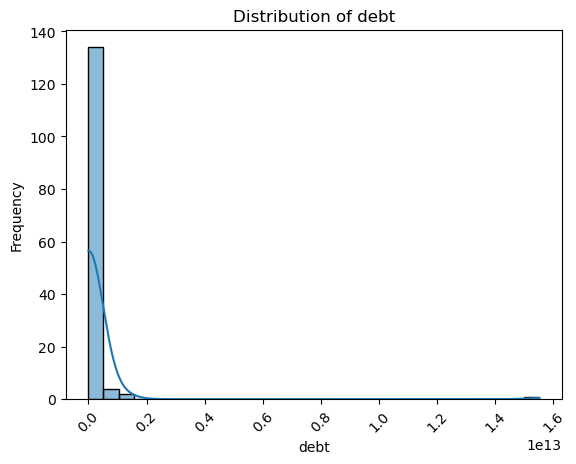

In [131]:
numerical_cols = dfQ.select_dtypes(include = ["float64", "int64"]).columns

for col in numerical_cols:
    plt.figure()
    sns.histplot(dfQ[col], kde = True, bins = 30) # set kernel density estimation to true for the curve
    plt.title("Distribution of {}".format(col))
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.xticks(rotation = 45)
    plt.show()

## Analysis 1 - Graph Standardized Difference by country

### Create Shared DataFrame

In [134]:
dfWB_shared = dfWB[shared_order]
dfQ_shared = dfQ[shared_order]

display(dfWB_shared.head())
display(dfQ_shared.head())


,countryName,year,population,populationDensityKm,yearsExisted,gdpNominal,gdpNominalPerCapita,giniCoefficient,humanDevelopmentIndex,inflationRate,unemploymentRate,grossExternalDebt
0,Afghanistan,2023.0,42239854.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.386,NaN
1,Afghanistan,2022.0,41128771.0,NaN,62.879,1.450216e+10,352.603733,NaN,NaN,NaN,14.100,3.393247e+09
2,Afghanistan,2021.0,40099462.0,61.480554,61.982,1.426650e+10,355.777826,NaN,NaN,NaN,11.934,3.555784e+09
3,Afghanistan,2020.0,38972230.0,59.752281,62.575,1.995593e+10,512.055098,NaN,0.400284,NaN,11.710,3.040072e+09
4,Afghanistan,2019.0,37769499.0,57.908252,63.565,1.879944e+10,497.741431,NaN,NaN,2.302373,11.224,2.661686e+09


,countryName,year,population,populationDensityKm,yearsExisted,gdpNominal,gdpNominalPerCapita,giniCoefficient,humanDevelopmentIndex,inflationRate,unemploymentRate,grossExternalDebt
0,Afghanistan,2022.0,38346720.0,48.08,NaN,2.165700e+10,493.0,NaN,0.478,4.5,23.9,1.400000e+09
1,Albania,2022.0,2793592.0,97.00,NaN,1.794200e+10,6260.0,34.299999,0.796,2.0,13.1,9.505000e+09
2,Algeria,2021.0,44700000.0,17.70,NaN,1.871550e+11,4151.0,27.600000,0.745,4.1,11.7,6.260000e+09
3,Andorra,2020.0,77543.0,179.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,2022.0,34795287.0,24.97,14.0,1.254960e+11,3793.0,51.299999,0.581,15.0,6.6,4.208000e+10


In [135]:
df_shared = pd.merge(dfWB_shared, dfQ_shared, on = ["countryName", "year"], how = "inner", suffixes = ("_dfWB", "_dfQ"))
display(df_shared)

,countryName,year,population_dfWB,populationDensityKm_dfWB,yearsExisted_dfWB,gdpNominal_dfWB,gdpNominalPerCapita_dfWB,giniCoefficient_dfWB,humanDevelopmentIndex_dfWB,inflationRate_dfWB,...,population_dfQ,populationDensityKm_dfQ,yearsExisted_dfQ,gdpNominal_dfQ,gdpNominalPerCapita_dfQ,giniCoefficient_dfQ,humanDevelopmentIndex_dfQ,inflationRate_dfQ,unemploymentRate_dfQ,grossExternalDebt_dfQ
0,Afghanistan,2022.0,4.112877e+07,NaN,62.879000,1.450216e+10,352.603733,NaN,NaN,NaN,...,3.834672e+07,48.080,NaN,2.165700e+10,493.0,NaN,0.478,4.500000,23.900000,1.400000e+09
1,Albania,2022.0,2.777689e+06,NaN,76.833000,1.891638e+10,6810.114041,NaN,NaN,6.725203,...,2.793592e+06,97.000,NaN,1.794200e+10,6260.0,34.299999,0.796,2.000000,13.100000,9.505000e+09
2,Algeria,2021.0,4.417797e+07,18.548603,76.377000,1.862654e+11,4216.251285,NaN,NaN,7.226063,...,4.470000e+07,17.700,NaN,1.871550e+11,4151.0,27.600000,0.745,4.100000,11.700000,6.260000e+09
3,Andorra,2020.0,7.770000e+04,165.319149,NaN,2.891001e+09,37207.221999,NaN,NaN,NaN,...,7.754300e+04,179.800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,2022.0,3.558899e+07,NaN,61.929000,1.043997e+11,2933.484644,NaN,NaN,21.355290,...,3.479529e+07,24.970,14.0,1.254960e+11,3793.0,51.299999,0.581,15.000000,6.600000,4.208000e+10
5,Armenia,2022.0,2.780469e+06,NaN,73.372000,1.951347e+10,7018.051504,27.9,NaN,8.640911,...,3.000756e+06,101.500,29.0,1.361200e+10,4595.0,29.900000,0.759,0.800000,18.355000,1.041000e+10
6,Austria,2022.0,9.041851e+06,NaN,81.092683,4.709419e+11,52084.681195,NaN,NaN,8.546870,...,9.027999e+06,107.600,NaN,4.798200e+11,53320.0,26.700001,0.916,1.600000,7.650000,6.308000e+11
7,Azerbaijan,2022.0,1.014176e+07,NaN,73.488000,7.880747e+10,7770.594223,NaN,NaN,13.852259,...,1.035330e+07,117.000,NaN,5.462200e+10,5398.0,33.700001,0.756,3.300000,7.766667,8.927000e+09
8,Barbados,2019.0,2.801800e+05,651.581395,77.257000,5.367139e+09,19156.039867,NaN,NaN,4.100290,...,2.870250e+05,660.000,NaN,5.207000e+09,18133.0,NaN,0.790,3.688000,10.100000,4.490000e+09
9,Belarus,2022.0,9.228071e+06,NaN,73.111463,7.377518e+10,7994.648061,NaN,NaN,15.209675,...,9.413505e+06,45.800,30.0,5.770800e+10,6133.0,25.299999,0.808,4.800000,4.800000,3.992000e+10


In [136]:
df_shared.columns.tolist()

['countryName',
 'year',
 'population_dfWB',
 'populationDensityKm_dfWB',
 'yearsExisted_dfWB',
 'gdpNominal_dfWB',
 'gdpNominalPerCapita_dfWB',
 'giniCoefficient_dfWB',
 'humanDevelopmentIndex_dfWB',
 'inflationRate_dfWB',
 'unemploymentRate_dfWB',
 'grossExternalDebt_dfWB',
 'population_dfQ',
 'populationDensityKm_dfQ',
 'yearsExisted_dfQ',
 'gdpNominal_dfQ',
 'gdpNominalPerCapita_dfQ',
 'giniCoefficient_dfQ',
 'humanDevelopmentIndex_dfQ',
 'inflationRate_dfQ',
 'unemploymentRate_dfQ',
 'grossExternalDebt_dfQ']

### Standardize the Data in df_shared and Find the Difference
- Future work could be to see how the map that is later made compares to the map that uses MinMaxScaler to remove the mean and normalize instead of standardize the values at this step

In [142]:
df_shared_standardized = df_shared[["countryName", "year"]].copy()

columns_to_standardize = [
    "population", 
    "populationDensityKm", 
    "yearsExisted", 
    "gdpNominal", 
    "gdpNominalPerCapita", 
    "giniCoefficient", 
    "humanDevelopmentIndex", 
    "inflationRate", 
    "unemploymentRate", 
    "grossExternalDebt"
]

scaler = StandardScaler()

for col in columns_to_standardize:
    WBcol = f"{col}_dfWB"
    Qcol = f"{col}_dfQ"
    
    df_shared_standardized[WBcol] = scaler.fit_transform(df_shared[[WBcol]])
    df_shared_standardized[Qcol] = scaler.fit_transform(df_shared[[Qcol]])

print("Standardized DataFrame:")
display(df_shared_standardized.head())

Standardized DataFrame:


,countryName,year,population_dfWB,population_dfQ,populationDensityKm_dfWB,populationDensityKm_dfQ,yearsExisted_dfWB,yearsExisted_dfQ,gdpNominal_dfWB,gdpNominal_dfQ,...,giniCoefficient_dfWB,giniCoefficient_dfQ,humanDevelopmentIndex_dfWB,humanDevelopmentIndex_dfQ,inflationRate_dfWB,inflationRate_dfQ,unemploymentRate_dfWB,unemploymentRate_dfQ,grossExternalDebt_dfWB,grossExternalDebt_dfQ
0,Afghanistan,2022.0,0.032030,0.018469,NaN,-0.130162,-1.032483,NaN,-0.394717,-0.410821,...,NaN,NaN,NaN,-1.512322,NaN,-0.168905,1.182152,-0.213459,-0.439988,-0.354811
1,Albania,2022.0,-0.252134,-0.252811,NaN,-0.130120,0.757611,NaN,-0.389044,-0.415419,...,NaN,-0.407800,NaN,0.506748,-0.237999,-0.234900,0.733370,-0.213541,-0.373575,-0.346897
2,Algeria,2021.0,0.054624,0.066946,-0.249776,-0.130188,0.699113,NaN,-0.173976,-0.205982,...,NaN,-1.161472,NaN,0.182935,-0.216587,-0.179464,1.094075,-0.213552,-0.402506,-0.350065
3,Andorra,2020.0,-0.272140,-0.273535,-0.204551,-0.130050,NaN,NaN,-0.409639,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,2022.0,-0.009017,-0.008630,NaN,-0.130181,-1.154354,-0.947318,-0.279186,-0.282298,...,NaN,1.504503,NaN,-0.858347,0.387435,0.108272,1.288094,-0.213590,0.093375,-0.315089


In [144]:
df_standardized_diff = df_shared[["countryName", "year"]].copy()

columns_to_diff = [
    "population", 
    "populationDensityKm", 
    "yearsExisted", 
    "gdpNominal", 
    "gdpNominalPerCapita", 
    "giniCoefficient", 
    "humanDevelopmentIndex", 
    "inflationRate", 
    "unemploymentRate", 
    "grossExternalDebt"
]

for col in columns_to_diff:
    WBcol = f"{col}_dfWB"
    Qcol = f"{col}_dfQ"
        
    df_standardized_diff[col] = df_shared_standardized[WBcol] - df_shared_standardized[Qcol]

print("Difference between standardized values:")
display(df_standardized_diff.head())
    

Difference between standardized values:


,countryName,year,population,populationDensityKm,yearsExisted,gdpNominal,gdpNominalPerCapita,giniCoefficient,humanDevelopmentIndex,inflationRate,unemploymentRate,grossExternalDebt
0,Afghanistan,2022.0,0.013562,NaN,NaN,0.016104,0.066121,NaN,NaN,NaN,1.395611,-0.085177
1,Albania,2022.0,0.000676,NaN,NaN,0.026375,0.058141,NaN,NaN,-0.003099,0.946911,-0.026678
2,Algeria,2021.0,-0.012322,-0.119588,NaN,0.032005,0.052876,NaN,NaN,-0.037123,1.307626,-0.052440
3,Andorra,2020.0,0.001395,-0.074501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,2022.0,-0.000387,NaN,-0.207036,0.003112,0.022314,NaN,NaN,0.279162,1.501684,0.408464


In [146]:
df_shared.info()
print()
df_standardized_diff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   countryName                 120 non-null    object 
 1   year                        120 non-null    float64
 2   population_dfWB             119 non-null    float64
 3   populationDensityKm_dfWB    30 non-null     float64
 4   yearsExisted_dfWB           116 non-null    float64
 5   gdpNominal_dfWB             118 non-null    float64
 6   gdpNominalPerCapita_dfWB    118 non-null    float64
 7   giniCoefficient_dfWB        22 non-null     float64
 8   humanDevelopmentIndex_dfWB  13 non-null     float64
 9   inflationRate_dfWB          106 non-null    float64
 10  unemploymentRate_dfWB       110 non-null    float64
 11  grossExternalDebt_dfWB      77 non-null     float64
 12  population_dfQ              120 non-null    float64
 13  populationDensityKm_dfQ     120 non

### Compute the Average of the Difference of the Standardized Values of Each Row

In [149]:
columns_to_avg = [
    "population", 
    "populationDensityKm", 
    "yearsExisted", 
    "gdpNominal", 
    "gdpNominalPerCapita", 
    "giniCoefficient", 
    "humanDevelopmentIndex", 
    "inflationRate", 
    "unemploymentRate", 
    "grossExternalDebt"
]

df_standardized_diff["meanDifferenceOfStdVals"] = df_standardized_diff[columns_to_avg].mean(axis = 1)

display(df_standardized_diff)


,countryName,year,population,populationDensityKm,yearsExisted,gdpNominal,gdpNominalPerCapita,giniCoefficient,humanDevelopmentIndex,inflationRate,unemploymentRate,grossExternalDebt,meanDifferenceOfStdVals
0,Afghanistan,2022.0,0.013562,NaN,NaN,0.016104,0.066121,NaN,NaN,NaN,1.395611,-0.085177,0.281244
1,Albania,2022.0,0.000676,NaN,NaN,0.026375,0.058141,NaN,NaN,-0.003099,0.946911,-0.026678,0.167054
2,Algeria,2021.0,-0.012322,-0.119588,NaN,0.032005,0.052876,NaN,NaN,-0.037123,1.307626,-0.052440,0.167291
3,Andorra,2020.0,0.001395,-0.074501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.036553
4,Angola,2022.0,-0.000387,NaN,-0.207036,0.003112,0.022314,NaN,NaN,0.279162,1.501684,0.408464,0.286759
5,Armenia,2022.0,-0.000884,NaN,0.565058,0.032502,0.133426,-0.522364,NaN,0.110475,0.414479,0.012503,0.093149
6,Austria,2022.0,-0.000479,NaN,NaN,0.035619,-0.268298,NaN,NaN,0.085336,-0.231457,NaN,-0.075856
7,Azerbaijan,2022.0,-0.002442,NaN,NaN,0.057944,0.127151,NaN,NaN,0.267264,-0.113903,0.019235,0.059208
8,Barbados,2019.0,0.001296,0.074925,NaN,0.024725,0.008301,NaN,NaN,-0.159873,0.379703,NaN,0.054846
9,Belarus,2022.0,-0.002041,NaN,0.485243,0.047658,0.105041,NaN,NaN,0.285697,-0.484769,0.219543,0.093767


### Map Previous Calculated Column By Country

<Axes: >

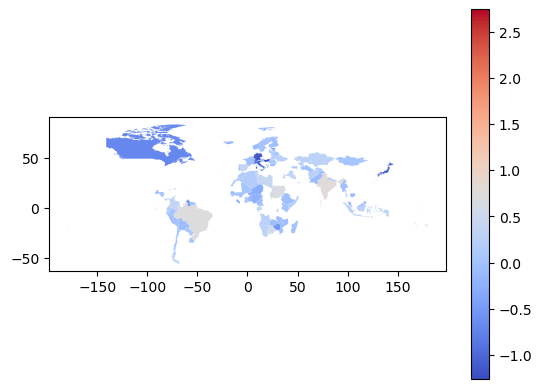

In [152]:
world = gpd.read_file("ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp")
world = world.merge(df_standardized_diff, left_on = "ADMIN", right_on = "countryName", how = "left")
world.plot(column = "meanDifferenceOfStdVals", cmap = "coolwarm", legend = True)

***Note:***
- Most of the data for each country is from 2022 but some is from 2018, 2019, 2020, and 2021.
- If there is a difference between the world bank and query data, the query data tends to be larger.
- Note the scale - light blue is 0 and not gray.
- White countries is missing data - either initially missing, dropped during the joining of tables because of different names, or dropped during the computation of the final mapped values.

### Compute the Average of the Average of the Difference of the Standardized Values of Each Row

In [155]:
avg_of_the_average_difference_of_the_std_vals = df_standardized_diff["meanDifferenceOfStdVals"].mean(axis = 0)

print("Average of the average differnce of the standardized values:")
print(avg_of_the_average_difference_of_the_std_vals)

Average of the average differnce of the standardized values:
0.01804065042263209


### Plot Previous Calculated Value on Gaussian Distribution

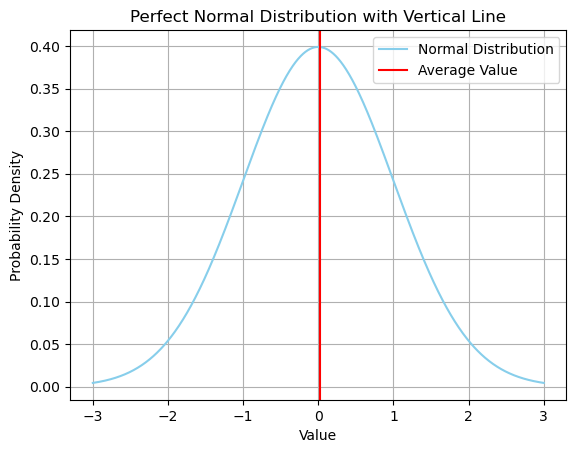

In [157]:
mean = 0  # mean of the distribution
std_dev = 1  # stdv of the distribution

x = np.linspace(-3, 3, 1000)  # generate 1000 points between -4 and 4

y = norm.pdf(x, mean, std_dev)  # probability density function

plt.plot(x, y, label = "Normal Distribution", color = "skyblue")
plt.axvline(x = avg_of_the_average_difference_of_the_std_vals, color = "red", label = "Average Value")
plt.title("Perfect Normal Distribution with Vertical Line")
plt.xlabel("Value")
plt.ylabel("Probability Density")
plt.legend()
plt.grid()
plt.show()

***Note:***
- This is suggesting that the DBpedia is more accurate than I previously would have thought even with the outliers assuming that the World Bank data is the best data we have.

### Compute the Average Difference of the Standardized Values of Each Column

In [160]:
mean_standardized_diff_by_col_dict = {}
for col in columns_to_diff:
    mean_standardized_diff_by_col_dict[col] = float(df_standardized_diff[col].mean())

print(mean_standardized_diff_by_col_dict)

{'population': -0.002302888443904058, 'populationDensityKm': -0.3901117124837477, 'yearsExisted': -0.029501126438668937, 'gdpNominal': 0.03727869385414543, 'gdpNominalPerCapita': -0.028565854605656173, 'giniCoefficient': -0.2144220133110592, 'humanDevelopmentIndex': 0.02926815953710822, 'inflationRate': -0.008780051854864518, 'unemploymentRate': 0.06985569274568192, 'grossExternalDebt': 0.39972562371532133}


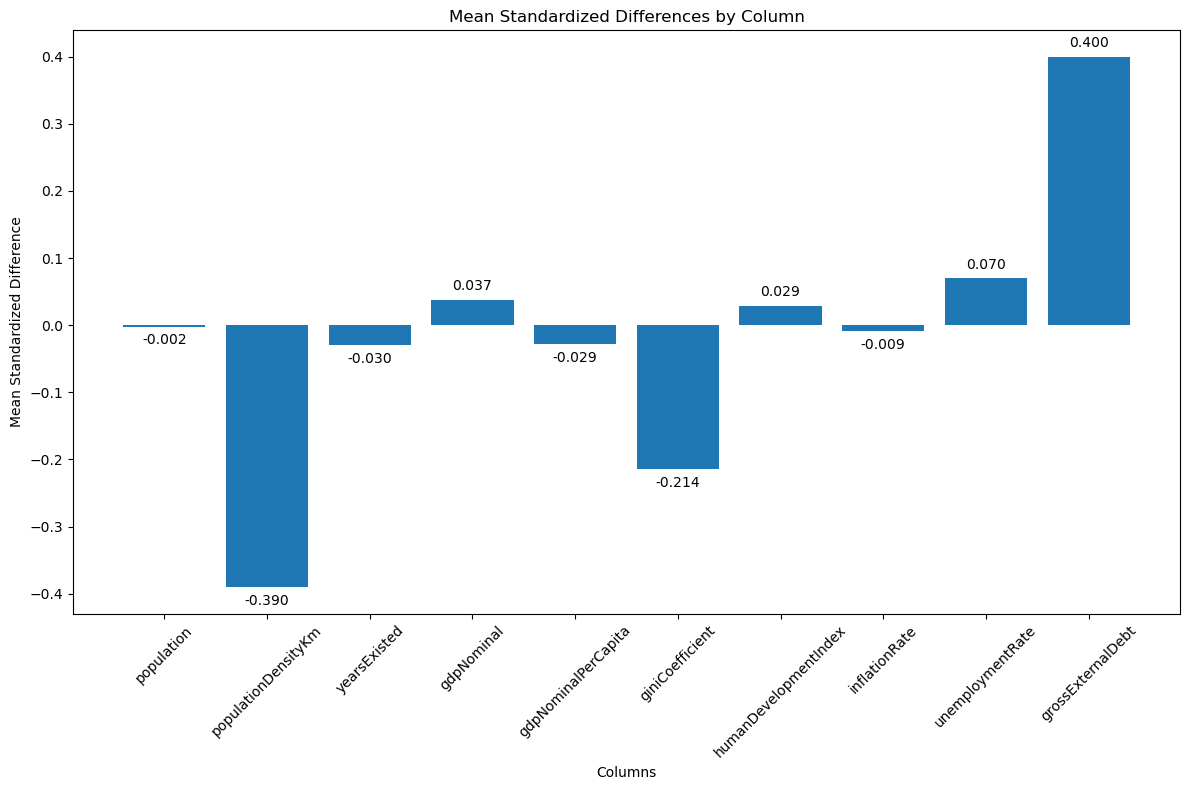

In [161]:
keys = list(mean_standardized_diff_by_col_dict.keys())
values = list(mean_standardized_diff_by_col_dict.values())

plt.figure(figsize = (12, 8))
bars = plt.bar(keys, values)
plt.title("Mean Standardized Differences by Column")
plt.xlabel("Columns")
plt.ylabel("Mean Standardized Difference")
plt.xticks(rotation = 45)

for i, bar in enumerate(bars):
    height = bar.get_height()
    value = values[i]
    va = "bottom" if value >= 0 else "top"
    y_offset = 0.01 if value >= 0 else -0.01
    plt.text(bar.get_x() + bar.get_width() / 2, value + y_offset,
             f"{value:.3f}", ha = "center", va = va)

plt.tight_layout()
plt.show()

## Analysis 2 - Model Prediction

***Note:***
- In this section, the models are designed to predict country happiness.
- We will also try and analyze which factors are most impactful and significant in the prediction.
- The data we will be using is the dbpedia data joined with country happiness data by country from World Happiness Report.

### Get World Happiness Data

In [167]:
happiness_data = pd.read_excel("DataForTable2.1.xls")
display(happiness_data.head())

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.723590,7.350416,0.450662,50.500000,0.718114,0.164055,0.881686,0.414297,0.258195
1,Afghanistan,2009,4.401778,7.508646,0.552308,50.799999,0.678896,0.187297,0.850035,0.481421,0.237092
2,Afghanistan,2010,4.758381,7.613900,0.539075,51.099998,0.600127,0.117861,0.706766,0.516907,0.275324
3,Afghanistan,2011,3.831719,7.581259,0.521104,51.400002,0.495901,0.160098,0.731109,0.479835,0.267175
4,Afghanistan,2012,3.782938,7.660506,0.520637,51.700001,0.530935,0.234157,0.775620,0.613513,0.267919


### Combine Happiness and Query Data and Drop Data
**Note:** 
- The variable for happiness is "life ladder"
    - Link to appendix of the data:
      <br>https://happiness-report.s3.amazonaws.com/2024/Ch2+Appendix.pdf

In [170]:
combined_data = pd.merge(dfQ, happiness_data, left_on = "countryName", right_on = "Country name", how = "inner")
display(combined_data.head())

# remove nonumerical columns
combined_data = combined_data.drop(columns = ["year_y", "year_x","Year", "Country", "Country name"], errors = "ignore")
# remove every column from world happiness dataset except life ladder
# this is done so we can predict life ladder (happiness) using just the 
# dbpedia collect data in the models
combined_data = combined_data.drop(columns = ["Log GDP per capita", "Social support", "Healthy life expectancy at birth", "Freedom to make life choices", "Generosity", "Perceptions of corruption", "Positive affect", "Negative affect"], errors = "ignore")

# drop rows with NULL values
combined_data = combined_data.dropna()

display(combined_data.head())

,countryName,year_x,population,populationDensityKm,yearsExisted,gdpNominal,gdpNominalPerCapita,giniCoefficient,humanDevelopmentIndex,inflationRate,...,year_y,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2022.0,38346720.0,48.08,NaN,2.165700e+10,493.0,NaN,0.478,4.5,...,2008,3.723590,7.350416,0.450662,50.500000,0.718114,0.164055,0.881686,0.414297,0.258195
1,Afghanistan,2022.0,38346720.0,48.08,NaN,2.165700e+10,493.0,NaN,0.478,4.5,...,2009,4.401778,7.508646,0.552308,50.799999,0.678896,0.187297,0.850035,0.481421,0.237092
2,Afghanistan,2022.0,38346720.0,48.08,NaN,2.165700e+10,493.0,NaN,0.478,4.5,...,2010,4.758381,7.613900,0.539075,51.099998,0.600127,0.117861,0.706766,0.516907,0.275324
3,Afghanistan,2022.0,38346720.0,48.08,NaN,2.165700e+10,493.0,NaN,0.478,4.5,...,2011,3.831719,7.581259,0.521104,51.400002,0.495901,0.160098,0.731109,0.479835,0.267175
4,Afghanistan,2022.0,38346720.0,48.08,NaN,2.165700e+10,493.0,NaN,0.478,4.5,...,2012,3.782938,7.660506,0.520637,51.700001,0.530935,0.234157,0.775620,0.613513,0.267919


,countryName,population,populationDensityKm,yearsExisted,gdpNominal,gdpNominalPerCapita,giniCoefficient,humanDevelopmentIndex,inflationRate,unemploymentRate,grossExternalDebt,conflictCount,governmentType,gdpPpp,debt,Life Ladder
42,Angola,34795287.0,24.97,14.0,1.254960e+11,3793.0,51.299999,0.581,15.0,6.600,4.208000e+10,21.0,Unitary_state,2.130340e+11,65.0,5.589001
43,Angola,34795287.0,24.97,14.0,1.254960e+11,3793.0,51.299999,0.581,15.0,6.600,4.208000e+10,21.0,Unitary_state,2.130340e+11,65.0,4.360250
44,Angola,34795287.0,24.97,14.0,1.254960e+11,3793.0,51.299999,0.581,15.0,6.600,4.208000e+10,21.0,Unitary_state,2.130340e+11,65.0,3.937107
45,Angola,34795287.0,24.97,14.0,1.254960e+11,3793.0,51.299999,0.581,15.0,6.600,4.208000e+10,21.0,Unitary_state,2.130340e+11,65.0,3.794838
64,Armenia,3000756.0,101.50,29.0,1.361200e+10,4595.0,29.900000,0.759,0.8,18.355,1.041000e+10,24.0,Unitary_parliamentary_republic,4.355000e+10,53.5,4.289311


### Normalize the Combined Data

In [174]:
country_names = combined_data["countryName"]
numerical_columns = combined_data.select_dtypes(include = ["float64", "int64"]).columns

scaler = MinMaxScaler()
normalized_data = pd.DataFrame(scaler.fit_transform(combined_data[numerical_columns]), 
                               columns = numerical_columns)

normalized_data["countryName"] = country_names
columns_order = ["countryName"] + list(numerical_columns)
normalized_data = normalized_data[columns_order]
combined_data = normalized_data # combined data is now normalized data, normalize data still saved

display(combined_data.head())

,countryName,population,populationDensityKm,yearsExisted,gdpNominal,gdpNominalPerCapita,giniCoefficient,humanDevelopmentIndex,inflationRate,unemploymentRate,grossExternalDebt,conflictCount,gdpPpp,debt,Life Ladder
0,NaN,0.135733,0.048939,0.162162,0.041693,0.073439,0.905537,0.286017,0.004021,0.000008,0.007819,0.068259,0.044484,5.327801e-11,0.605124
1,NaN,0.135733,0.048939,0.162162,0.041693,0.073439,0.905537,0.286017,0.004021,0.000008,0.007819,0.068259,0.044484,5.327801e-11,0.348328
2,NaN,0.135733,0.048939,0.162162,0.041693,0.073439,0.905537,0.286017,0.004021,0.000008,0.007819,0.068259,0.044484,5.327801e-11,0.259896
3,NaN,0.135733,0.048939,0.162162,0.041693,0.073439,0.905537,0.286017,0.004021,0.000008,0.007819,0.068259,0.044484,5.327801e-11,0.230163
4,NaN,0.003704,0.212489,0.364865,0.003543,0.091584,0.208469,0.663136,0.000019,0.000023,0.001786,0.078498,0.007986,4.373444e-11,0.333503


### Split Data

In [176]:
X = combined_data.drop(columns = ["Life Ladder"])  
X = X.select_dtypes(include = [float, int])  
y = combined_data["Life Ladder"]

# split data 80/20 between train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

print("X_train shape:\n", X_train.shape)
print("X_test shape:\n", X_test.shape)
print("y_train shape:\n", y_train.shape)
print("y_test shape:\n", y_test.shape)

X_train shape:
 (459, 13)
X_test shape:
 (115, 13)
y_train shape:
 (459,)
y_test shape:
 (115,)


### Linear Regression

In [180]:
LR_regression_model = LinearRegression()
LR_regression_model.fit(X_train, y_train)

y_pred = LR_regression_model.predict(X_test)

print("Linear Regression R2 Score:\n", r2_score(y_test, y_pred))

coefficients = LR_regression_model.coef_
feature_names = X_train.columns

coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# sort the dataframe
coef_df['Absolute Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by = 'Absolute Coefficient', ascending = False).drop(columns = 'Absolute Coefficient')

print("\nLinear Regression Coefficients:")
print(coef_df)

Linear Regression R2 Score:
 0.5757021004373113

Linear Regression Coefficients:
                  Feature  Coefficient
3              gdpNominal     0.967472
11                 gdpPpp    -0.874827
6   humanDevelopmentIndex     0.529428
9       grossExternalDebt    -0.418967
0              population     0.308216
5         giniCoefficient     0.126109
2            yearsExisted     0.121988
12                   debt     0.115066
7           inflationRate     0.101267
8        unemploymentRate    -0.091291
1     populationDensityKm    -0.083745
10          conflictCount    -0.013692
4     gdpNominalPerCapita     0.010847


### Decision Tree Regressor

**Make Decision Tree and Make Prediction With It**

In [186]:
dt = DecisionTreeRegressor(random_state = 0)

dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)

dt_r2_score = r2_score(y_test, y_pred_dt)

print("Decision Tree R2 Score:", dt_r2_score)

Decision Tree R2 Score: 0.8130011843737752


**Print Decision Tree Structure**

In [189]:
tree_structure = export_text(dt, feature_names = list(X_train.columns))

print("Decision Tree Structure:")
print()
print(tree_structure)

Decision Tree Structure:

|--- humanDevelopmentIndex <= 0.36
|   |--- grossExternalDebt <= 0.00
|   |   |--- unemploymentRate <= 0.00
|   |   |   |--- yearsExisted <= 0.34
|   |   |   |   |--- inflationRate <= 0.05
|   |   |   |   |   |--- value: [0.20]
|   |   |   |   |--- inflationRate >  0.05
|   |   |   |   |   |--- value: [0.23]
|   |   |   |--- yearsExisted >  0.34
|   |   |   |   |--- grossExternalDebt <= 0.00
|   |   |   |   |   |--- value: [0.29]
|   |   |   |   |--- grossExternalDebt >  0.00
|   |   |   |   |   |--- gdpNominal <= 0.01
|   |   |   |   |   |   |--- value: [0.27]
|   |   |   |   |   |--- gdpNominal >  0.01
|   |   |   |   |   |   |--- value: [0.25]
|   |   |--- unemploymentRate >  0.00
|   |   |   |--- value: [0.46]
|   |--- grossExternalDebt >  0.00
|   |   |--- unemploymentRate <= 0.00
|   |   |   |--- value: [0.33]
|   |   |--- unemploymentRate >  0.00
|   |   |   |--- populationDensityKm <= 0.05
|   |   |   |   |--- value: [0.37]
|   |   |   |--- populationD

**Evaluate the Importance of Each Feature**

In [192]:
feature_importance = dt.feature_importances_
feature_names = X_train.columns
importance_dict = dict(zip(feature_names, feature_importance))

print("Feature Importance:")
for feature, importance in sorted(importance_dict.items(), key = lambda x: x[1], reverse = True):
    print("{}: {:.4f}".format(feature, importance))
print()


Feature Importance:
humanDevelopmentIndex: 0.5524
grossExternalDebt: 0.1925
unemploymentRate: 0.1259
yearsExisted: 0.1117
gdpNominal: 0.0083
populationDensityKm: 0.0027
gdpPpp: 0.0026
inflationRate: 0.0024
giniCoefficient: 0.0009
conflictCount: 0.0006
population: 0.0000
gdpNominalPerCapita: 0.0000
debt: 0.0000



### Random Forest Regressor

In [195]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

rf_r2_score = r2_score(y_test, y_pred_rf)

print("Random Forest R2 Score:", rf_r2_score)

Random Forest R2 Score: 0.8129855177063207


### Neural Network Regressor

**Build the Neural Network Regressor**

In [199]:
NN_regressor_model = keras.Sequential([
    keras.layers.Dense(169, input_dim = 13, activation = "relu"),
    keras.layers.Dense(13, activation = "relu"),
    keras.layers.Dense(1) # no activation because this is a regression and we want a single value
])

NN_regressor_model.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ["mse", "mae"])

**Train the Neural Network Regressor**

In [201]:
NN_regressor_model_results = NN_regressor_model.fit(X_train, y_train, epochs = 100, batch_size = 32, validation_split = 0.2, verbose = 1)

Epoch 1/100
12/12 [==============================] - 2s 55ms/step - loss: 0.0615 - mse: 0.0615 - mae: 0.2068 - val_loss: 0.0323 - val_mse: 0.0323 - val_mae: 0.1425
Epoch 2/100
12/12 [==============================] - 0s 5ms/step - loss: 0.0276 - mse: 0.0276 - mae: 0.1332 - val_loss: 0.0215 - val_mse: 0.0215 - val_mae: 0.1203
Epoch 3/100
12/12 [==============================] - 0s 5ms/step - loss: 0.0207 - mse: 0.0207 - mae: 0.1101 - val_loss: 0.0185 - val_mse: 0.0185 - val_mae: 0.1055
Epoch 4/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0179 - mse: 0.0179 - mae: 0.1020 - val_loss: 0.0170 - val_mse: 0.0170 - val_mae: 0.1048
Epoch 5/100
12/12 [==============================] - 0s 5ms/step - loss: 0.0168 - mse: 0.0168 - mae: 0.1003 - val_loss: 0.0158 - val_mse: 0.0158 - val_mae: 0.1008
Epoch 6/100
12/12 [==============================] - 0s 5ms/step - loss: 0.0161 - mse: 0.0161 - mae: 0.0975 - val_loss: 0.0154 - val_mse: 0.0154 - val_mae: 0.0991
Epoch 7/100
12/12 [==

**Plot the Loss Curves**

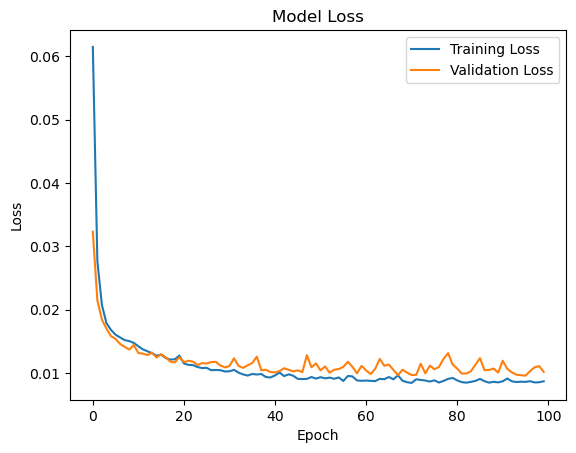

In [204]:
plt.plot(NN_regressor_model_results.history["loss"], label = "Training Loss")
plt.plot(NN_regressor_model_results.history["val_loss"], label = "Validation Loss")
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

**Predict Using the Neural Network Regressor and Evaluate Performance**

In [206]:
y_pred_nn = NN_regressor_model.predict(X_test)
y_pred_nn = y_pred_nn.flatten()

mae = np.mean(np.abs(y_test - y_pred_nn))
mse = np.mean((y_test - y_pred_nn)**2)
r2 = r2_score(y_test, y_pred_nn)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")

4/4 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.07169523989040348
Mean Squared Error: 0.008211902172520128
R2 Score: 0.8005825995828512


### Model Conclusions
The performance of the models was ranked from best to worst:
1) Decision Tree Regressor
2) Random Forest Regressor
3) Neural Network Regressor
4) Linear Regression

The Decision Tree Regressor is the preferred model for our purposes because not only does it make the best predictions but the model also is the most interpretable. It shows that human development index is by far the most important of the feature inputted when making a prediction. Future work could be to experiment mixing and matching features to see how well the model performs in order to gain a sense of which features become more important in the absence of others. 